In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_ela = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_ela = os.path.join(folder_AGVA, 'Derived products', 'S2', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[:14] for i in os.listdir(folder_ela) if i!='merged.vrt' ] ))
# rgis_to_analyze.sort()

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

3023


In [4]:
skip = 0
for i in range(len(rgis_to_analyze)):
#     if i!=0: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
#     if rgiid!='RGI60-01.00557': continue
        
    rgiid = rgis_to_analyze[i]
    # check if we've already run this glacier. if so, skip
    temp_path = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
#     if os.path.exists(temp_path):
#         continue

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]

#     if ga<2800: continue
    
    # print progress
    print(f"\nStarting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # open glacier mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    # define the coarsen scale
    if ga>1000:
        scale=5
    elif ga>500:
        scale=3
        
    if ga>500:
        glacier_mask = glacier_mask.coarsen({"x":scale, "y":scale}, boundary="trim").median(skipna=True).astype('uint8')
        
    # open the ela dataframe
    path_open = os.path.join(folder_save, "ELAs", f"{rgiid}_ELAs.csv")
    ela_df = pd.read_csv(path_open)
    
#     print(ela_df)
    
    # throw out anything that has <XYZ% observed
    ela_df_good = ela_df[ela_df['observed_after_smoothing']>0.7]
    ela_df_good = ela_df_good[ela_df_good['observed_initial']>0.3]
    
    # now for each year, get the maximum ela
    annual_best = []
    
    bad_dates = []
    bad_elas = []
    expected_elas = []
    bad_dates2 = []
    bad_elas2 = []
    expected_elas2 = []
    
    for y in [2018,2019,2020,2021,2022]:
#         if y!=2020: continue
#         print(y)
        # decide which of the columns you are going to want to save
        cols_to_save = ['date', 'ela', 'observed_after_smoothing', 'aar', 'off_glacier']
        
        # subset to this year. note we only consider obs in the july-november time frame
        elas_this_year = ela_df_good[ (ela_df_good['date']>=f'{y}-07-01') & (ela_df_good['date']<f'{y}-12-01')].copy()
        
#         print(elas_this_year.shape)
        # add doy
        elas_this_year['date_dt'] = [datetime.strptime(i, "%Y-%m-%d") for i in elas_this_year['date'] ]
        elas_this_year['doy'] = [i.timetuple().tm_yday for i in elas_this_year['date_dt'] ]
        
        # if len=0, we have no good data so we save a null point
        n_obs = len(elas_this_year)
        if n_obs==0:
            annual_best.append(pd.Series({"date":f"{y}-01-01", "ela":-9999, 'fraction_observed':-9999, 'aar':-9999, 'off_glacier':-9999}))
        
#         else:
        # else we decide which the best of the elas is and save that info
        else:
            
            ### filter out the ELA outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:
                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    ela_diff = row['ela']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=200
                    if ela_diff<=tolerance:
                        continue
                    
                    # or if we predicted a negative slope, then all bets are off
                    elif bestfit.coef_[0]<0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<15:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
#                         bad_dates.append(row['date'])
#                         bad_elas.append(row['ela'])
#                         expected_elas.append(pred)
                        elas_this_year.drop(idx, inplace=True) 
                   
                
                
            ### filter out the AAR outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:

                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y2)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    aar_diff = row['aar']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=-0.15
                    if aar_diff>=tolerance:
                        continue
                    
                    # or if we predicted a positive slope, then all bets are off
                    elif bestfit.coef_[0]>0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<10:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
#                         bad_dates2.append(row['date'])
#                         bad_elas2.append(row['aar'])
#                         expected_elas2.append(pred)
                        elas_this_year.drop(idx, inplace=True) 
            
            # find the maximum ela
            ela_max = np.nanmax(elas_this_year['ela'])

            # get all the dates that had this ela
            ela_max_all = elas_this_year[elas_this_year['ela']==ela_max]

            # we'll take the one that has the minimum aar to be the 'best' estimate
            # for example, if the ela is well above the glacier, there are likely many dates with the same ela found
            ela_max_best = ela_max_all.loc[ela_max_all['aar'].idxmin()]
            
            # find the minimum aar
            aar_min = np.nanmin(elas_this_year['aar'])
            aar_min_all = elas_this_year[elas_this_year['aar']==aar_min]
            aar_min_best = aar_min_all.loc[aar_min_all['ela'].idxmax()]
            
            # choose which to use
            best = ela_max_best #ela_max_best, aar_min_best
            
            # save this data
            annual_best.append(best[cols_to_save])
            
    ### save all the data here
    
    # function to format metadata and attributes
    def format_xr_to_save(xr_da):
        xr_da.attrs["res"] = (10,10)
        xr_da.attrs["crs"] = "EPSG:3338"
        xr_da.attrs["transform"] = [10,0,0,0,-10,0]
        xr_da.attrs["_FillValue"] = 0
        xr_da.attrs["long_name"] = rgiid
        xr_da.attrs["description"] = "0: nan, 1: ablation, 2: accumulation"
        xr_da.name = "accumulation_area"

        xr_da.x.attrs["units"] = "meters"
        xr_da.y.attrs["units"] = "meters"
        xr_da.x.attrs["long_name"] = 'x'
        xr_da.y.attrs["long_name"] = 'y'

        return xr_da
    
    # set folder paths, etc...
    path_df_all = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
    path_xr_all = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_2018_2022_annual_AAs.nc")
    path_xr_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.nc")
    path_tif_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")
    
    # one year at a time, get the snow distributions
    all_maps = []
    for s in annual_best:
        
        # get date
        d = s['date']
        y = d[:4]
        
        # skip the null years
        if d[5:7]=='01': continue
        
        # open the snow distribution map
        if ga>2800:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_coarse_smoothed.nc")
        elif ga>500:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_coarse_smoothed.nc")
#             path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_coarse_smoothed.nc")
#             path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_smoothed.nc")
        else:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_smoothed.nc")
#             path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_smoothed.nc")
        
        snow = xr.open_dataset(path_open, chunks={'time':1})['class'].sel(time=d)
        
        # add to list to save
        all_maps.append(snow.copy())
        
        # save each as a tif
        path_out = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_{y}_AA.tif")
        snow = format_xr_to_save(snow)
        snow.rio.to_raster(raster_path=path_out, compress='DEFLATE')
#         encoding = {"accumulation_area":{"zlib": True}}
#         snow.rio.to_raster(raster_path=path_out, encoding=encoding)
        
    # format to save maps as long as there is usable imagery
    if len(all_maps)>0:
        
        # compute average map
        all_maps = xr.concat(all_maps, dim='time')
        all_maps = all_maps.where(all_maps.isin([1,2]), np.nan)
        average_map = all_maps.median('time', skipna=True).astype('uint8')#+glacier_mask
        
        save_xr_all = format_xr_to_save(all_maps.astype('uint8'))
        save_xr_avg = format_xr_to_save(average_map)

        # specify compression/encoding
        encoding = {"accumulation_area":{"zlib": True}}
        
        # save
        save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
        save_xr_avg.rio.to_raster(raster_path=path_tif_avg, compress='DEFLATE')

    # always save the csv
    annual_best = pd.DataFrame(annual_best)
    annual_best.to_csv(path_df_all, index=False) # table with annual end-of-summer ela, aar, date, fraction observed

print('All done!')


Starting 1 of 3023: RGI60-01.20889  2.0 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2 of 3023: RGI60-01.11632  2.0 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3 of 3023: RGI60-01.25183  2.002 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 4 of 3023: RGI60-01.08203  2.002 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 5 of 3023: RGI60-01.11595  2.003 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 6 of 3023: RGI60-01.03614  2.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 7 of 3023: RGI60-01.09047  2.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 8 of 3023: RGI60-01.05487  2.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 9 of 3023: RGI60-01.17509  2.005 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 10 of 3023: RGI60-01.03088  2.005 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 11 of 3023: RGI60-01.10867  2.005 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 12 of 3023: RGI60-01.08199  2.006 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 13 of 3023: RGI60-01.02453  2.006 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 14 of 3023: RGI60-01.12977  2.006 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 15 of 3023: RGI60-01.19457  2.007 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 16 of 3023: RGI60-01.05254  2.009 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 17 of 3023: RGI60-01.02906  2.01 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 18 of 3023: RGI60-01.03773  2.012 km2

Starting 19 of 3023: RGI60-01.19826  2.012 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 20 of 3023: RGI60-01.00315  2.014 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 21 of 3023: RGI60-01.00564  2.015 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 22 of 3023: RGI60-01.08366  2.016 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 23 of 3023: RGI60-01.02527  2.016 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 24 of 3023: RGI60-01.23281  2.019 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 25 of 3023: RGI60-01.02588  2.02 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 26 of 3023: RGI60-01.05127  2.02 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 27 of 3023: RGI60-01.22309  2.021 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 28 of 3023: RGI60-01.12245  2.021 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 29 of 3023: RGI60-01.10523  2.022 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 30 of 3023: RGI60-01.21347  2.024 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 31 of 3023: RGI60-01.19932  2.024 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 32 of 3023: RGI60-01.09386  2.025 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 33 of 3023: RGI60-01.23153  2.026 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 34 of 3023: RGI60-01.06549  2.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 35 of 3023: RGI60-01.20282  2.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 36 of 3023: RGI60-01.21828  2.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 37 of 3023: RGI60-01.07047  2.028 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 38 of 3023: RGI60-01.17170  2.028 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 39 of 3023: RGI60-01.07386  2.03 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 40 of 3023: RGI60-01.00600  2.031 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 41 of 3023: RGI60-01.05253  2.031 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 42 of 3023: RGI60-01.11873  2.031 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 43 of 3023: RGI60-01.02374  2.031 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 44 of 3023: RGI60-01.05168  2.032 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 45 of 3023: RGI60-01.01802  2.033 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 46 of 3023: RGI60-01.16227  2.034 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 47 of 3023: RGI60-01.02504  2.034 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 48 of 3023: RGI60-01.00890  2.035 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 49 of 3023: RGI60-01.03380  2.036 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 50 of 3023: RGI60-01.11767  2.036 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 51 of 3023: RGI60-01.19669  2.036 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 52 of 3023: RGI60-01.09340  2.037 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 53 of 3023: RGI60-01.19186  2.037 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 54 of 3023: RGI60-01.11631  2.037 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 55 of 3023: RGI60-01.23552  2.038 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 56 of 3023: RGI60-01.20952  2.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 57 of 3023: RGI60-01.13235  2.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 58 of 3023: RGI60-01.20961  2.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 59 of 3023: RGI60-01.18877  2.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 60 of 3023: RGI60-01.19502  2.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 61 of 3023: RGI60-01.20578  2.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 62 of 3023: RGI60-01.19470  2.044 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 63 of 3023: RGI60-01.15496  2.045 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 64 of 3023: RGI60-01.07438  2.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 65 of 3023: RGI60-01.05672  2.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 66 of 3023: RGI60-01.03302  2.047 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 67 of 3023: RGI60-01.23070  2.047 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 68 of 3023: RGI60-01.00694  2.048 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 69 of 3023: RGI60-01.16484  2.048 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 70 of 3023: RGI60-01.19283  2.049 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 71 of 3023: RGI60-01.21782  2.05 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 72 of 3023: RGI60-01.00295  2.05 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 73 of 3023: RGI60-01.15949  2.052 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 74 of 3023: RGI60-01.03420  2.053 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 75 of 3023: RGI60-01.25342  2.055 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 76 of 3023: RGI60-01.19660  2.056 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 77 of 3023: RGI60-01.14037  2.058 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 78 of 3023: RGI60-01.16135  2.058 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 79 of 3023: RGI60-01.15403  2.059 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 80 of 3023: RGI60-01.14476  2.059 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 81 of 3023: RGI60-01.23097  2.061 km2

Starting 82 of 3023: RGI60-01.23221  2.062 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 83 of 3023: RGI60-01.07485  2.062 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 84 of 3023: RGI60-01.02471  2.063 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 85 of 3023: RGI60-01.06347  2.063 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 86 of 3023: RGI60-01.04269  2.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 87 of 3023: RGI60-01.09720  2.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 88 of 3023: RGI60-01.09748  2.065 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 89 of 3023: RGI60-01.23573  2.066 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 90 of 3023: RGI60-01.12034  2.066 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 91 of 3023: RGI60-01.22687  2.067 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 92 of 3023: RGI60-01.19827  2.067 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 93 of 3023: RGI60-01.26205  2.068 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 94 of 3023: RGI60-01.07581  2.069 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 95 of 3023: RGI60-01.06098  2.069 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 96 of 3023: RGI60-01.18008  2.07 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 97 of 3023: RGI60-01.22644  2.07 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 98 of 3023: RGI60-01.19628  2.073 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 99 of 3023: RGI60-01.18011  2.073 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 100 of 3023: RGI60-01.02827  2.074 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 101 of 3023: RGI60-01.00641  2.075 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 102 of 3023: RGI60-01.23845  2.075 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 103 of 3023: RGI60-01.25198  2.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 104 of 3023: RGI60-01.09123  2.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 105 of 3023: RGI60-01.23315  2.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 106 of 3023: RGI60-01.22660  2.077 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 107 of 3023: RGI60-01.13640  2.078 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 108 of 3023: RGI60-01.13609  2.079 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 109 of 3023: RGI60-01.22706  2.079 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 110 of 3023: RGI60-01.05137  2.079 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 111 of 3023: RGI60-01.20808  2.081 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 112 of 3023: RGI60-01.16933  2.082 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 113 of 3023: RGI60-01.25139  2.082 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 114 of 3023: RGI60-01.08933  2.082 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 115 of 3023: RGI60-01.03969  2.083 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 116 of 3023: RGI60-01.10484  2.084 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 117 of 3023: RGI60-01.10910  2.084 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 118 of 3023: RGI60-01.09071  2.084 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 119 of 3023: RGI60-01.06866  2.086 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 120 of 3023: RGI60-01.15813  2.087 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 121 of 3023: RGI60-01.07318  2.088 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 122 of 3023: RGI60-01.17603  2.089 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 123 of 3023: RGI60-01.16251  2.092 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 124 of 3023: RGI60-01.10184  2.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 125 of 3023: RGI60-01.12564  2.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 126 of 3023: RGI60-01.20861  2.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 127 of 3023: RGI60-01.21832  2.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 128 of 3023: RGI60-01.00799  2.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 129 of 3023: RGI60-01.16197  2.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 130 of 3023: RGI60-01.05377  2.099 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 131 of 3023: RGI60-01.00313  2.099 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 132 of 3023: RGI60-01.00034  2.101 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 133 of 3023: RGI60-01.08896  2.102 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 134 of 3023: RGI60-01.16500  2.105 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 135 of 3023: RGI60-01.16683  2.105 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 136 of 3023: RGI60-01.17380  2.105 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 137 of 3023: RGI60-01.19916  2.107 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 138 of 3023: RGI60-01.19527  2.107 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 139 of 3023: RGI60-01.19652  2.108 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 140 of 3023: RGI60-01.07681  2.108 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 141 of 3023: RGI60-01.15952  2.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 142 of 3023: RGI60-01.09117  2.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 143 of 3023: RGI60-01.06197  2.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 144 of 3023: RGI60-01.08132  2.11 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 145 of 3023: RGI60-01.05054  2.111 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 146 of 3023: RGI60-01.01002  2.111 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 147 of 3023: RGI60-01.03402  2.112 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 148 of 3023: RGI60-01.14018  2.113 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 149 of 3023: RGI60-01.00537  2.113 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 150 of 3023: RGI60-01.22200  2.113 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 151 of 3023: RGI60-01.20504  2.114 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 152 of 3023: RGI60-01.03205  2.115 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 153 of 3023: RGI60-01.22192  2.115 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 154 of 3023: RGI60-01.11518  2.116 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 155 of 3023: RGI60-01.24848  2.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 156 of 3023: RGI60-01.23042  2.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 157 of 3023: RGI60-01.14182  2.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 158 of 3023: RGI60-01.17429  2.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 159 of 3023: RGI60-01.08815  2.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 160 of 3023: RGI60-01.18755  2.118 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 161 of 3023: RGI60-01.05479  2.118 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 162 of 3023: RGI60-01.05260  2.119 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 163 of 3023: RGI60-01.02905  2.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 164 of 3023: RGI60-01.00732  2.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 165 of 3023: RGI60-01.08258  2.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 166 of 3023: RGI60-01.03027  2.121 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 167 of 3023: RGI60-01.18729  2.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 168 of 3023: RGI60-01.16650  2.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 169 of 3023: RGI60-01.19770  2.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 170 of 3023: RGI60-01.18978  2.123 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 171 of 3023: RGI60-01.07101  2.123 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 172 of 3023: RGI60-01.00787  2.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 173 of 3023: RGI60-01.12496  2.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 174 of 3023: RGI60-01.19963  2.127 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 175 of 3023: RGI60-01.15543  2.128 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 176 of 3023: RGI60-01.17519  2.128 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 177 of 3023: RGI60-01.13830  2.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 178 of 3023: RGI60-01.00559  2.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 179 of 3023: RGI60-01.02945  2.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 180 of 3023: RGI60-01.00077  2.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 181 of 3023: RGI60-01.03179  2.132 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 182 of 3023: RGI60-01.10856  2.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 183 of 3023: RGI60-01.20866  2.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 184 of 3023: RGI60-01.00670  2.134 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 185 of 3023: RGI60-01.05455  2.135 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 186 of 3023: RGI60-01.09107  2.137 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 187 of 3023: RGI60-01.06230  2.138 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 188 of 3023: RGI60-01.01671  2.138 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 189 of 3023: RGI60-01.01786  2.138 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 190 of 3023: RGI60-01.23682  2.139 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 191 of 3023: RGI60-01.24747  2.139 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 192 of 3023: RGI60-01.22792  2.139 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 193 of 3023: RGI60-01.23254  2.14 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 194 of 3023: RGI60-01.07055  2.14 km2

Starting 195 of 3023: RGI60-01.04994  2.141 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 196 of 3023: RGI60-01.23669  2.142 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 197 of 3023: RGI60-01.18960  2.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 198 of 3023: RGI60-01.13590  2.144 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 199 of 3023: RGI60-01.21185  2.145 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 200 of 3023: RGI60-01.04295  2.147 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 201 of 3023: RGI60-01.20914  2.148 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 202 of 3023: RGI60-01.13028  2.149 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 203 of 3023: RGI60-01.03404  2.15 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 204 of 3023: RGI60-01.10969  2.156 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 205 of 3023: RGI60-01.08346  2.156 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 206 of 3023: RGI60-01.00314  2.156 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 207 of 3023: RGI60-01.03414  2.157 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 208 of 3023: RGI60-01.24911  2.158 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 209 of 3023: RGI60-01.17892  2.158 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 210 of 3023: RGI60-01.11557  2.159 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 211 of 3023: RGI60-01.00390  2.16 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 212 of 3023: RGI60-01.00159  2.161 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 213 of 3023: RGI60-01.21768  2.162 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 214 of 3023: RGI60-01.25410  2.162 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 215 of 3023: RGI60-01.11611  2.164 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 216 of 3023: RGI60-01.04534  2.167 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 217 of 3023: RGI60-01.24574  2.169 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 218 of 3023: RGI60-01.20454  2.17 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 219 of 3023: RGI60-01.15483  2.17 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 220 of 3023: RGI60-01.05153  2.171 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 221 of 3023: RGI60-01.15195  2.171 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 222 of 3023: RGI60-01.24659  2.171 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 223 of 3023: RGI60-01.23194  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 224 of 3023: RGI60-01.23580  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 225 of 3023: RGI60-01.15933  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 226 of 3023: RGI60-01.18163  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 227 of 3023: RGI60-01.11889  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 228 of 3023: RGI60-01.03412  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 229 of 3023: RGI60-01.20545  2.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 230 of 3023: RGI60-01.00852  2.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 231 of 3023: RGI60-01.19039  2.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 232 of 3023: RGI60-01.14200  2.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 233 of 3023: RGI60-01.03016  2.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 234 of 3023: RGI60-01.15216  2.175 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 235 of 3023: RGI60-01.22954  2.175 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 236 of 3023: RGI60-01.16154  2.177 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 237 of 3023: RGI60-01.25143  2.178 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 238 of 3023: RGI60-01.03565  2.178 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 239 of 3023: RGI60-01.20161  2.178 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 240 of 3023: RGI60-01.00686  2.178 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 241 of 3023: RGI60-01.10916  2.179 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 242 of 3023: RGI60-01.18790  2.181 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 243 of 3023: RGI60-01.20306  2.182 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 244 of 3023: RGI60-01.12921  2.182 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 245 of 3023: RGI60-01.03709  2.182 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 246 of 3023: RGI60-01.02378  2.184 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 247 of 3023: RGI60-01.04453  2.184 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 248 of 3023: RGI60-01.12341  2.185 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 249 of 3023: RGI60-01.01644  2.189 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 250 of 3023: RGI60-01.23657  2.191 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 251 of 3023: RGI60-01.03431  2.191 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 252 of 3023: RGI60-01.26587  2.192 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 253 of 3023: RGI60-01.07428  2.193 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 254 of 3023: RGI60-01.23089  2.196 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 255 of 3023: RGI60-01.02788  2.197 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 256 of 3023: RGI60-01.20863  2.197 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 257 of 3023: RGI60-01.04214  2.198 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 258 of 3023: RGI60-01.06029  2.198 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 259 of 3023: RGI60-01.20600  2.199 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 260 of 3023: RGI60-01.14414  2.199 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 261 of 3023: RGI60-01.17408  2.199 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 262 of 3023: RGI60-01.06343  2.2 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 263 of 3023: RGI60-01.08251  2.2 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 264 of 3023: RGI60-01.26866  2.201 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 265 of 3023: RGI60-01.07292  2.201 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 266 of 3023: RGI60-01.11715  2.202 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 267 of 3023: RGI60-01.04616  2.203 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 268 of 3023: RGI60-01.23043  2.204 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 269 of 3023: RGI60-01.23022  2.205 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 270 of 3023: RGI60-01.13396  2.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 271 of 3023: RGI60-01.20311  2.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 272 of 3023: RGI60-01.24235  2.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 273 of 3023: RGI60-01.03323  2.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 274 of 3023: RGI60-01.16901  2.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 275 of 3023: RGI60-01.12473  2.208 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 276 of 3023: RGI60-01.06171  2.208 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 277 of 3023: RGI60-01.05871  2.211 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 278 of 3023: RGI60-01.04007  2.211 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 279 of 3023: RGI60-01.01739  2.212 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 280 of 3023: RGI60-01.17474  2.213 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 281 of 3023: RGI60-01.11839  2.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 282 of 3023: RGI60-01.23048  2.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 283 of 3023: RGI60-01.23551  2.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 284 of 3023: RGI60-01.16731  2.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 285 of 3023: RGI60-01.01335  2.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 286 of 3023: RGI60-01.02444  2.217 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 287 of 3023: RGI60-01.19025  2.217 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 288 of 3023: RGI60-01.04213  2.218 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 289 of 3023: RGI60-01.05369  2.218 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 290 of 3023: RGI60-01.03311  2.218 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 291 of 3023: RGI60-01.21955  2.219 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 292 of 3023: RGI60-01.05618  2.219 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 293 of 3023: RGI60-01.10570  2.22 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 294 of 3023: RGI60-01.08648  2.22 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 295 of 3023: RGI60-01.16036  2.221 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 296 of 3023: RGI60-01.23187  2.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 297 of 3023: RGI60-01.03390  2.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 298 of 3023: RGI60-01.05264  2.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 299 of 3023: RGI60-01.03400  2.224 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 300 of 3023: RGI60-01.19779  2.225 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 301 of 3023: RGI60-01.19654  2.226 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 302 of 3023: RGI60-01.19459  2.226 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 303 of 3023: RGI60-01.09829  2.228 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 304 of 3023: RGI60-01.24797  2.23 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 305 of 3023: RGI60-01.25624  2.23 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 306 of 3023: RGI60-01.03298  2.231 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 307 of 3023: RGI60-01.14221  2.232 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 308 of 3023: RGI60-01.01625  2.233 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 309 of 3023: RGI60-01.04643  2.233 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 310 of 3023: RGI60-01.17196  2.235 km2

Starting 311 of 3023: RGI60-01.04658  2.236 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 312 of 3023: RGI60-01.03767  2.237 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 313 of 3023: RGI60-01.04770  2.237 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 314 of 3023: RGI60-01.11318  2.238 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 315 of 3023: RGI60-01.04956  2.24 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 316 of 3023: RGI60-01.12219  2.24 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 317 of 3023: RGI60-01.16896  2.24 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 318 of 3023: RGI60-01.20460  2.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 319 of 3023: RGI60-01.03507  2.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 320 of 3023: RGI60-01.23090  2.246 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 321 of 3023: RGI60-01.02964  2.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 322 of 3023: RGI60-01.03411  2.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 323 of 3023: RGI60-01.12464  2.248 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 324 of 3023: RGI60-01.17797  2.249 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 325 of 3023: RGI60-01.04525  2.249 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 326 of 3023: RGI60-01.22184  2.252 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 327 of 3023: RGI60-01.08270  2.252 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 328 of 3023: RGI60-01.14401  2.254 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 329 of 3023: RGI60-01.24720  2.254 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 330 of 3023: RGI60-01.23195  2.255 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 331 of 3023: RGI60-01.23545  2.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 332 of 3023: RGI60-01.23266  2.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 333 of 3023: RGI60-01.07061  2.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 334 of 3023: RGI60-01.18043  2.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 335 of 3023: RGI60-01.20283  2.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 336 of 3023: RGI60-01.07094  2.257 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 337 of 3023: RGI60-01.06196  2.258 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 338 of 3023: RGI60-01.20334  2.259 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 339 of 3023: RGI60-01.22633  2.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 340 of 3023: RGI60-01.05541  2.261 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 341 of 3023: RGI60-01.03148  2.262 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 342 of 3023: RGI60-01.17769  2.267 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 343 of 3023: RGI60-01.03204  2.267 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 344 of 3023: RGI60-01.05959  2.268 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 345 of 3023: RGI60-01.17424  2.272 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 346 of 3023: RGI60-01.08455  2.273 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 347 of 3023: RGI60-01.05339  2.273 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 348 of 3023: RGI60-01.05161  2.274 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 349 of 3023: RGI60-01.13177  2.274 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 350 of 3023: RGI60-01.01278  2.275 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 351 of 3023: RGI60-01.21276  2.275 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 352 of 3023: RGI60-01.20198  2.275 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 353 of 3023: RGI60-01.07046  2.276 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 354 of 3023: RGI60-01.15491  2.277 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 355 of 3023: RGI60-01.19385  2.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 356 of 3023: RGI60-01.03688  2.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 357 of 3023: RGI60-01.04161  2.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 358 of 3023: RGI60-01.20508  2.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 359 of 3023: RGI60-01.05049  2.279 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 360 of 3023: RGI60-01.15254  2.279 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 361 of 3023: RGI60-01.13917  2.28 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 362 of 3023: RGI60-01.16834  2.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 363 of 3023: RGI60-01.16288  2.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 364 of 3023: RGI60-01.08681  2.282 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 365 of 3023: RGI60-01.08080  2.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 366 of 3023: RGI60-01.01721  2.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 367 of 3023: RGI60-01.01331  2.285 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 368 of 3023: RGI60-01.19568  2.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 369 of 3023: RGI60-01.20974  2.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 370 of 3023: RGI60-01.08472  2.287 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 371 of 3023: RGI60-01.19871  2.29 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 372 of 3023: RGI60-01.23693  2.29 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 373 of 3023: RGI60-01.03227  2.29 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 374 of 3023: RGI60-01.23535  2.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 375 of 3023: RGI60-01.24144  2.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 376 of 3023: RGI60-01.05070  2.293 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 377 of 3023: RGI60-01.21396  2.293 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 378 of 3023: RGI60-01.16392  2.294 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 379 of 3023: RGI60-01.15774  2.295 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 380 of 3023: RGI60-01.20320  2.295 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 381 of 3023: RGI60-01.19807  2.298 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 382 of 3023: RGI60-01.11476  2.298 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 383 of 3023: RGI60-01.01758  2.3 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 384 of 3023: RGI60-01.12157  2.301 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 385 of 3023: RGI60-01.24867  2.301 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 386 of 3023: RGI60-01.20745  2.302 km2

Starting 387 of 3023: RGI60-01.03812  2.303 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 388 of 3023: RGI60-01.22777  2.303 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 389 of 3023: RGI60-01.18202  2.303 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 390 of 3023: RGI60-01.05239  2.304 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 391 of 3023: RGI60-01.19847  2.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 392 of 3023: RGI60-01.05798  2.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 393 of 3023: RGI60-01.19571  2.307 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 394 of 3023: RGI60-01.01223  2.307 km2

Starting 395 of 3023: RGI60-01.16690  2.307 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 396 of 3023: RGI60-01.22806  2.307 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 397 of 3023: RGI60-01.06446  2.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 398 of 3023: RGI60-01.05124  2.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 399 of 3023: RGI60-01.02879  2.311 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 400 of 3023: RGI60-01.16482  2.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 401 of 3023: RGI60-01.05224  2.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 402 of 3023: RGI60-01.03976  2.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 403 of 3023: RGI60-01.23337  2.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 404 of 3023: RGI60-01.02620  2.314 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 405 of 3023: RGI60-01.02875  2.315 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 406 of 3023: RGI60-01.04014  2.318 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 407 of 3023: RGI60-01.16515  2.318 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 408 of 3023: RGI60-01.09822  2.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 409 of 3023: RGI60-01.05307  2.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 410 of 3023: RGI60-01.25705  2.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 411 of 3023: RGI60-01.19858  2.32 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 412 of 3023: RGI60-01.23569  2.322 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 413 of 3023: RGI60-01.09517  2.322 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 414 of 3023: RGI60-01.22803  2.324 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 415 of 3023: RGI60-01.13969  2.325 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 416 of 3023: RGI60-01.13315  2.325 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 417 of 3023: RGI60-01.15962  2.326 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 418 of 3023: RGI60-01.02615  2.328 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 419 of 3023: RGI60-01.01275  2.328 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 420 of 3023: RGI60-01.23235  2.329 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 421 of 3023: RGI60-01.19045  2.329 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 422 of 3023: RGI60-01.11571  2.333 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 423 of 3023: RGI60-01.19623  2.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 424 of 3023: RGI60-01.21072  2.335 km2

Starting 425 of 3023: RGI60-01.18918  2.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 426 of 3023: RGI60-01.15123  2.336 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 427 of 3023: RGI60-01.20510  2.337 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 428 of 3023: RGI60-01.20500  2.337 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 429 of 3023: RGI60-01.16608  2.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 430 of 3023: RGI60-01.23330  2.339 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 431 of 3023: RGI60-01.08391  2.34 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 432 of 3023: RGI60-01.15738  2.341 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 433 of 3023: RGI60-01.02624  2.342 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 434 of 3023: RGI60-01.02532  2.343 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 435 of 3023: RGI60-01.04396  2.343 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 436 of 3023: RGI60-01.09414  2.343 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 437 of 3023: RGI60-01.08348  2.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 438 of 3023: RGI60-01.23606  2.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 439 of 3023: RGI60-01.06194  2.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 440 of 3023: RGI60-01.11308  2.345 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 441 of 3023: RGI60-01.22152  2.345 km2

Starting 442 of 3023: RGI60-01.22254  2.348 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 443 of 3023: RGI60-01.03177  2.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 444 of 3023: RGI60-01.16754  2.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 445 of 3023: RGI60-01.08175  2.35 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 446 of 3023: RGI60-01.13945  2.35 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 447 of 3023: RGI60-01.04134  2.351 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 448 of 3023: RGI60-01.19469  2.351 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 449 of 3023: RGI60-01.11543  2.352 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 450 of 3023: RGI60-01.12752  2.352 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 451 of 3023: RGI60-01.24073  2.353 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 452 of 3023: RGI60-01.18110  2.356 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 453 of 3023: RGI60-01.04402  2.358 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 454 of 3023: RGI60-01.13343  2.358 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 455 of 3023: RGI60-01.10369  2.359 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 456 of 3023: RGI60-01.22090  2.361 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 457 of 3023: RGI60-01.23236  2.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 458 of 3023: RGI60-01.10908  2.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 459 of 3023: RGI60-01.14361  2.364 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 460 of 3023: RGI60-01.05764  2.366 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 461 of 3023: RGI60-01.20025  2.366 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 462 of 3023: RGI60-01.17175  2.366 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 463 of 3023: RGI60-01.06195  2.367 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 464 of 3023: RGI60-01.02970  2.367 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 465 of 3023: RGI60-01.09255  2.367 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 466 of 3023: RGI60-01.07270  2.368 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 467 of 3023: RGI60-01.11132  2.372 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 468 of 3023: RGI60-01.03203  2.372 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 469 of 3023: RGI60-01.00348  2.374 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 470 of 3023: RGI60-01.15317  2.374 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 471 of 3023: RGI60-01.24951  2.376 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 472 of 3023: RGI60-01.26387  2.377 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 473 of 3023: RGI60-01.17377  2.38 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 474 of 3023: RGI60-01.26517  2.381 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 475 of 3023: RGI60-01.08913  2.381 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 476 of 3023: RGI60-01.24828  2.382 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 477 of 3023: RGI60-01.03295  2.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 478 of 3023: RGI60-01.19799  2.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 479 of 3023: RGI60-01.17095  2.386 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 480 of 3023: RGI60-01.19058  2.389 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 481 of 3023: RGI60-01.21257  2.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 482 of 3023: RGI60-01.07281  2.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 483 of 3023: RGI60-01.16655  2.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 484 of 3023: RGI60-01.01213  2.395 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 485 of 3023: RGI60-01.03108  2.396 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 486 of 3023: RGI60-01.05237  2.397 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 487 of 3023: RGI60-01.19124  2.397 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 488 of 3023: RGI60-01.04015  2.398 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 489 of 3023: RGI60-01.24952  2.399 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 490 of 3023: RGI60-01.04596  2.399 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)



Starting 491 of 3023: RGI60-01.03883  2.4 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 492 of 3023: RGI60-01.14201  2.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 493 of 3023: RGI60-01.22233  2.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 494 of 3023: RGI60-01.17711  2.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 495 of 3023: RGI60-01.16726  2.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 496 of 3023: RGI60-01.24944  2.405 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 497 of 3023: RGI60-01.18167  2.407 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 498 of 3023: RGI60-01.06457  2.407 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 499 of 3023: RGI60-01.22235  2.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 500 of 3023: RGI60-01.19475  2.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 501 of 3023: RGI60-01.14586  2.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 502 of 3023: RGI60-01.17720  2.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 503 of 3023: RGI60-01.04280  2.41 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 504 of 3023: RGI60-01.20268  2.41 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 505 of 3023: RGI60-01.25130  2.412 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 506 of 3023: RGI60-01.23890  2.412 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 507 of 3023: RGI60-01.23062  2.413 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 508 of 3023: RGI60-01.04481  2.414 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 509 of 3023: RGI60-01.14194  2.414 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 510 of 3023: RGI60-01.01681  2.417 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 511 of 3023: RGI60-01.02452  2.418 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 512 of 3023: RGI60-01.19337  2.418 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 513 of 3023: RGI60-01.18679  2.419 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 514 of 3023: RGI60-01.19161  2.419 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 515 of 3023: RGI60-01.11573  2.424 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 516 of 3023: RGI60-01.13292  2.425 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 517 of 3023: RGI60-01.14942  2.426 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 518 of 3023: RGI60-01.09969  2.427 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 519 of 3023: RGI60-01.22559  2.427 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 520 of 3023: RGI60-01.16706  2.427 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 521 of 3023: RGI60-01.11971  2.428 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 522 of 3023: RGI60-01.19487  2.429 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 523 of 3023: RGI60-01.08064  2.431 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 524 of 3023: RGI60-01.03145  2.433 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 525 of 3023: RGI60-01.19053  2.436 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 526 of 3023: RGI60-01.20799  2.436 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 527 of 3023: RGI60-01.18932  2.436 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 528 of 3023: RGI60-01.06210  2.439 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 529 of 3023: RGI60-01.11882  2.439 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 530 of 3023: RGI60-01.15763  2.44 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 531 of 3023: RGI60-01.12424  2.44 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 532 of 3023: RGI60-01.25200  2.443 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 533 of 3023: RGI60-01.01276  2.444 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 534 of 3023: RGI60-01.06816  2.446 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 535 of 3023: RGI60-01.19656  2.449 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 536 of 3023: RGI60-01.12083  2.45 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 537 of 3023: RGI60-01.09450  2.451 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 538 of 3023: RGI60-01.05250  2.451 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 539 of 3023: RGI60-01.03385  2.453 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 540 of 3023: RGI60-01.19655  2.454 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 541 of 3023: RGI60-01.08643  2.455 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 542 of 3023: RGI60-01.26463  2.455 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 543 of 3023: RGI60-01.03194  2.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 544 of 3023: RGI60-01.08425  2.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 545 of 3023: RGI60-01.10560  2.462 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 546 of 3023: RGI60-01.05342  2.467 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 547 of 3023: RGI60-01.01292  2.469 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 548 of 3023: RGI60-01.17884  2.469 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 549 of 3023: RGI60-01.12410  2.469 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 550 of 3023: RGI60-01.22981  2.47 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 551 of 3023: RGI60-01.18634  2.47 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 552 of 3023: RGI60-01.05706  2.477 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 553 of 3023: RGI60-01.18562  2.478 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 554 of 3023: RGI60-01.18107  2.479 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 555 of 3023: RGI60-01.16733  2.482 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 556 of 3023: RGI60-01.26663  2.483 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 557 of 3023: RGI60-01.23196  2.483 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 558 of 3023: RGI60-01.12348  2.484 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 559 of 3023: RGI60-01.22372  2.484 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 560 of 3023: RGI60-01.16471  2.485 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 561 of 3023: RGI60-01.12781  2.486 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 562 of 3023: RGI60-01.03478  2.486 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 563 of 3023: RGI60-01.02417  2.487 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 564 of 3023: RGI60-01.23031  2.49 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 565 of 3023: RGI60-01.05112  2.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 566 of 3023: RGI60-01.01426  2.492 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 567 of 3023: RGI60-01.04718  2.493 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 568 of 3023: RGI60-01.15024  2.494 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 569 of 3023: RGI60-01.18314  2.494 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 570 of 3023: RGI60-01.01510  2.494 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 571 of 3023: RGI60-01.08303  2.495 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 572 of 3023: RGI60-01.24123  2.496 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 573 of 3023: RGI60-01.01819  2.496 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 574 of 3023: RGI60-01.16153  2.497 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 575 of 3023: RGI60-01.19184  2.497 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 576 of 3023: RGI60-01.09713  2.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 577 of 3023: RGI60-01.01783  2.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 578 of 3023: RGI60-01.23675  2.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 579 of 3023: RGI60-01.12014  2.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 580 of 3023: RGI60-01.00814  2.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 581 of 3023: RGI60-01.07522  2.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 582 of 3023: RGI60-01.04982  2.502 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 583 of 3023: RGI60-01.20807  2.502 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 584 of 3023: RGI60-01.17659  2.503 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 585 of 3023: RGI60-01.00368  2.504 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 586 of 3023: RGI60-01.16066  2.505 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 587 of 3023: RGI60-01.05291  2.505 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 588 of 3023: RGI60-01.11306  2.505 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 589 of 3023: RGI60-01.11690  2.506 km2

Starting 590 of 3023: RGI60-01.26986  2.507 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 591 of 3023: RGI60-01.23971  2.507 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 592 of 3023: RGI60-01.20639  2.509 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 593 of 3023: RGI60-01.08141  2.51 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 594 of 3023: RGI60-01.13383  2.512 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 595 of 3023: RGI60-01.03176  2.514 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 596 of 3023: RGI60-01.02316  2.517 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 597 of 3023: RGI60-01.16969  2.517 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 598 of 3023: RGI60-01.05791  2.517 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 599 of 3023: RGI60-01.03188  2.519 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 600 of 3023: RGI60-01.19668  2.52 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 601 of 3023: RGI60-01.24396  2.524 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 602 of 3023: RGI60-01.02808  2.524 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 603 of 3023: RGI60-01.18101  2.524 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 604 of 3023: RGI60-01.06077  2.526 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 605 of 3023: RGI60-01.11638  2.529 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 606 of 3023: RGI60-01.16147  2.53 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 607 of 3023: RGI60-01.19522  2.533 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 608 of 3023: RGI60-01.11501  2.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 609 of 3023: RGI60-01.04452  2.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 610 of 3023: RGI60-01.18150  2.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 611 of 3023: RGI60-01.03783  2.537 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 612 of 3023: RGI60-01.11334  2.539 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 613 of 3023: RGI60-01.16164  2.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 614 of 3023: RGI60-01.11610  2.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 615 of 3023: RGI60-01.15143  2.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 616 of 3023: RGI60-01.14005  2.541 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 617 of 3023: RGI60-01.04517  2.541 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 618 of 3023: RGI60-01.03752  2.542 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 619 of 3023: RGI60-01.15435  2.543 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 620 of 3023: RGI60-01.10932  2.543 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 621 of 3023: RGI60-01.09452  2.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 622 of 3023: RGI60-01.06785  2.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 623 of 3023: RGI60-01.22817  2.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 624 of 3023: RGI60-01.19710  2.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 625 of 3023: RGI60-01.20292  2.546 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 626 of 3023: RGI60-01.03893  2.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 627 of 3023: RGI60-01.26035  2.55 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 628 of 3023: RGI60-01.05669  2.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 629 of 3023: RGI60-01.26383  2.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 630 of 3023: RGI60-01.15253  2.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 631 of 3023: RGI60-01.03241  2.552 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 632 of 3023: RGI60-01.10902  2.556 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 633 of 3023: RGI60-01.23571  2.556 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 634 of 3023: RGI60-01.20775  2.556 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 635 of 3023: RGI60-01.10532  2.561 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 636 of 3023: RGI60-01.07370  2.562 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 637 of 3023: RGI60-01.19640  2.562 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 638 of 3023: RGI60-01.22453  2.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 639 of 3023: RGI60-01.04034  2.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 640 of 3023: RGI60-01.16693  2.569 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 641 of 3023: RGI60-01.05551  2.57 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 642 of 3023: RGI60-01.05026  2.57 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 643 of 3023: RGI60-01.26096  2.571 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 644 of 3023: RGI60-01.17523  2.572 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 645 of 3023: RGI60-01.00005  2.573 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 646 of 3023: RGI60-01.19286  2.575 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 647 of 3023: RGI60-01.03025  2.578 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 648 of 3023: RGI60-01.03379  2.578 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 649 of 3023: RGI60-01.03396  2.579 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 650 of 3023: RGI60-01.05651  2.581 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 651 of 3023: RGI60-01.04395  2.581 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 652 of 3023: RGI60-01.16177  2.582 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 653 of 3023: RGI60-01.03026  2.583 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 654 of 3023: RGI60-01.10098  2.584 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 655 of 3023: RGI60-01.08291  2.585 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 656 of 3023: RGI60-01.19709  2.588 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 657 of 3023: RGI60-01.04835  2.59 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 658 of 3023: RGI60-01.18827  2.59 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 659 of 3023: RGI60-01.01136  2.591 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 660 of 3023: RGI60-01.04471  2.591 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 661 of 3023: RGI60-01.09396  2.591 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 662 of 3023: RGI60-01.20288  2.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 663 of 3023: RGI60-01.20628  2.594 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 664 of 3023: RGI60-01.09557  2.594 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 665 of 3023: RGI60-01.08845  2.596 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 666 of 3023: RGI60-01.09209  2.597 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 667 of 3023: RGI60-01.20662  2.597 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 668 of 3023: RGI60-01.01704  2.597 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 669 of 3023: RGI60-01.00030  2.599 km2

Starting 670 of 3023: RGI60-01.04583  2.6 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 671 of 3023: RGI60-01.10350  2.6 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 672 of 3023: RGI60-01.05413  2.603 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 673 of 3023: RGI60-01.23388  2.603 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 674 of 3023: RGI60-01.12155  2.604 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 675 of 3023: RGI60-01.00426  2.606 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 676 of 3023: RGI60-01.22834  2.606 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 677 of 3023: RGI60-01.02544  2.607 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 678 of 3023: RGI60-01.08911  2.608 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 679 of 3023: RGI60-01.19995  2.608 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 680 of 3023: RGI60-01.11534  2.608 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 681 of 3023: RGI60-01.15566  2.61 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 682 of 3023: RGI60-01.05779  2.614 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 683 of 3023: RGI60-01.04860  2.615 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 684 of 3023: RGI60-01.18177  2.615 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 685 of 3023: RGI60-01.04919  2.616 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 686 of 3023: RGI60-01.04651  2.619 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 687 of 3023: RGI60-01.06702  2.621 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 688 of 3023: RGI60-01.04202  2.623 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 689 of 3023: RGI60-01.14430  2.624 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 690 of 3023: RGI60-01.01411  2.625 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 691 of 3023: RGI60-01.17817  2.626 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 692 of 3023: RGI60-01.17767  2.628 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 693 of 3023: RGI60-01.00399  2.628 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 694 of 3023: RGI60-01.14124  2.628 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 695 of 3023: RGI60-01.01606  2.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 696 of 3023: RGI60-01.00138  2.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 697 of 3023: RGI60-01.26315  2.63 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 698 of 3023: RGI60-01.08200  2.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 699 of 3023: RGI60-01.13841  2.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 700 of 3023: RGI60-01.08410  2.634 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 701 of 3023: RGI60-01.08374  2.635 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 702 of 3023: RGI60-01.03784  2.636 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 703 of 3023: RGI60-01.04055  2.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 704 of 3023: RGI60-01.03848  2.641 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 705 of 3023: RGI60-01.06113  2.644 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 706 of 3023: RGI60-01.10925  2.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 707 of 3023: RGI60-01.20853  2.649 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 708 of 3023: RGI60-01.01773  2.65 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 709 of 3023: RGI60-01.00901  2.654 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 710 of 3023: RGI60-01.08062  2.655 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 711 of 3023: RGI60-01.17905  2.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 712 of 3023: RGI60-01.08076  2.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 713 of 3023: RGI60-01.23757  2.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 714 of 3023: RGI60-01.03384  2.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 715 of 3023: RGI60-01.12281  2.657 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 716 of 3023: RGI60-01.01140  2.658 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 717 of 3023: RGI60-01.00870  2.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 718 of 3023: RGI60-01.01497  2.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 719 of 3023: RGI60-01.20556  2.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 720 of 3023: RGI60-01.13521  2.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 721 of 3023: RGI60-01.18589  2.664 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 722 of 3023: RGI60-01.10214  2.666 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 723 of 3023: RGI60-01.19886  2.666 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 724 of 3023: RGI60-01.08318  2.666 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 725 of 3023: RGI60-01.09684  2.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 726 of 3023: RGI60-01.22217  2.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 727 of 3023: RGI60-01.10340  2.672 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 728 of 3023: RGI60-01.19584  2.673 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 729 of 3023: RGI60-01.07379  2.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 730 of 3023: RGI60-01.00960  2.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 731 of 3023: RGI60-01.14634  2.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 732 of 3023: RGI60-01.00739  2.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 733 of 3023: RGI60-01.16719  2.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 734 of 3023: RGI60-01.20726  2.682 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 735 of 3023: RGI60-01.08081  2.684 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 736 of 3023: RGI60-01.04684  2.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 737 of 3023: RGI60-01.03744  2.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 738 of 3023: RGI60-01.05311  2.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 739 of 3023: RGI60-01.22206  2.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 740 of 3023: RGI60-01.15787  2.689 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 741 of 3023: RGI60-01.17268  2.69 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 742 of 3023: RGI60-01.23274  2.691 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 743 of 3023: RGI60-01.12305  2.693 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 744 of 3023: RGI60-01.03408  2.694 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 745 of 3023: RGI60-01.01407  2.696 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 746 of 3023: RGI60-01.03394  2.697 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 747 of 3023: RGI60-01.12168  2.698 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 748 of 3023: RGI60-01.22893  2.699 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 749 of 3023: RGI60-01.06174  2.699 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 750 of 3023: RGI60-01.03202  2.704 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 751 of 3023: RGI60-01.01469  2.705 km2

Starting 752 of 3023: RGI60-01.03937  2.707 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 753 of 3023: RGI60-01.13027  2.707 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 754 of 3023: RGI60-01.15710  2.708 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 755 of 3023: RGI60-01.26193  2.708 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 756 of 3023: RGI60-01.19241  2.709 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 757 of 3023: RGI60-01.11799  2.712 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 758 of 3023: RGI60-01.03882  2.715 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 759 of 3023: RGI60-01.01637  2.718 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 760 of 3023: RGI60-01.12125  2.718 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 761 of 3023: RGI60-01.02850  2.72 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 762 of 3023: RGI60-01.10441  2.721 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 763 of 3023: RGI60-01.13001  2.723 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 764 of 3023: RGI60-01.05936  2.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 765 of 3023: RGI60-01.03386  2.73 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 766 of 3023: RGI60-01.03418  2.735 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 767 of 3023: RGI60-01.18164  2.737 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 768 of 3023: RGI60-01.11857  2.738 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 769 of 3023: RGI60-01.15185  2.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 770 of 3023: RGI60-01.09031  2.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 771 of 3023: RGI60-01.14525  2.741 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 772 of 3023: RGI60-01.14333  2.744 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 773 of 3023: RGI60-01.07743  2.745 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 774 of 3023: RGI60-01.24661  2.748 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 775 of 3023: RGI60-01.04764  2.75 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 776 of 3023: RGI60-01.10551  2.75 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 777 of 3023: RGI60-01.19082  2.751 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 778 of 3023: RGI60-01.13563  2.751 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 779 of 3023: RGI60-01.04973  2.752 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 780 of 3023: RGI60-01.02946  2.752 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 781 of 3023: RGI60-01.00171  2.754 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 782 of 3023: RGI60-01.09178  2.754 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 783 of 3023: RGI60-01.14142  2.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 784 of 3023: RGI60-01.15259  2.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 785 of 3023: RGI60-01.10279  2.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 786 of 3023: RGI60-01.01589  2.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 787 of 3023: RGI60-01.17166  2.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 788 of 3023: RGI60-01.05100  2.758 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 789 of 3023: RGI60-01.26427  2.758 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 790 of 3023: RGI60-01.27106  2.758 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 791 of 3023: RGI60-01.07206  2.759 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 792 of 3023: RGI60-01.19711  2.76 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 793 of 3023: RGI60-01.00351  2.76 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 794 of 3023: RGI60-01.19526  2.761 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 795 of 3023: RGI60-01.12366  2.762 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 796 of 3023: RGI60-01.08662  2.766 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 797 of 3023: RGI60-01.02807  2.766 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 798 of 3023: RGI60-01.25586  2.768 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 799 of 3023: RGI60-01.16314  2.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 800 of 3023: RGI60-01.12101  2.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 801 of 3023: RGI60-01.20185  2.773 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 802 of 3023: RGI60-01.04850  2.774 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 803 of 3023: RGI60-01.01692  2.776 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 804 of 3023: RGI60-01.17851  2.777 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 805 of 3023: RGI60-01.08428  2.779 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 806 of 3023: RGI60-01.20486  2.782 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 807 of 3023: RGI60-01.23023  2.783 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 808 of 3023: RGI60-01.01647  2.783 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 809 of 3023: RGI60-01.00688  2.783 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 810 of 3023: RGI60-01.18778  2.787 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 811 of 3023: RGI60-01.19035  2.789 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 812 of 3023: RGI60-01.19349  2.792 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 813 of 3023: RGI60-01.18473  2.792 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 814 of 3023: RGI60-01.09766  2.793 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 815 of 3023: RGI60-01.22657  2.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 816 of 3023: RGI60-01.19534  2.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 817 of 3023: RGI60-01.11711  2.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 818 of 3023: RGI60-01.10768  2.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 819 of 3023: RGI60-01.08354  2.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 820 of 3023: RGI60-01.16136  2.798 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 821 of 3023: RGI60-01.11803  2.801 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 822 of 3023: RGI60-01.00012  2.802 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 823 of 3023: RGI60-01.05851  2.804 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 824 of 3023: RGI60-01.14786  2.806 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 825 of 3023: RGI60-01.23010  2.806 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 826 of 3023: RGI60-01.16852  2.806 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 827 of 3023: RGI60-01.02909  2.807 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 828 of 3023: RGI60-01.02607  2.808 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 829 of 3023: RGI60-01.23072  2.808 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 830 of 3023: RGI60-01.02791  2.808 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 831 of 3023: RGI60-01.04769  2.808 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 832 of 3023: RGI60-01.03797  2.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 833 of 3023: RGI60-01.01573  2.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 834 of 3023: RGI60-01.04653  2.811 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 835 of 3023: RGI60-01.18316  2.811 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 836 of 3023: RGI60-01.03395  2.811 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 837 of 3023: RGI60-01.19388  2.812 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 838 of 3023: RGI60-01.19598  2.814 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 839 of 3023: RGI60-01.16739  2.814 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 840 of 3023: RGI60-01.05496  2.815 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 841 of 3023: RGI60-01.19348  2.815 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 842 of 3023: RGI60-01.20515  2.817 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 843 of 3023: RGI60-01.05824  2.818 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 844 of 3023: RGI60-01.03136  2.82 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 845 of 3023: RGI60-01.04256  2.82 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 846 of 3023: RGI60-01.05630  2.821 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 847 of 3023: RGI60-01.08276  2.823 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 848 of 3023: RGI60-01.26389  2.826 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 849 of 3023: RGI60-01.04554  2.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 850 of 3023: RGI60-01.06323  2.828 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 851 of 3023: RGI60-01.24849  2.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 852 of 3023: RGI60-01.15767  2.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 853 of 3023: RGI60-01.01632  2.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 854 of 3023: RGI60-01.16286  2.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 855 of 3023: RGI60-01.23197  2.837 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 856 of 3023: RGI60-01.12771  2.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 857 of 3023: RGI60-01.10886  2.839 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 858 of 3023: RGI60-01.22497  2.839 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 859 of 3023: RGI60-01.16291  2.843 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 860 of 3023: RGI60-01.08176  2.843 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 861 of 3023: RGI60-01.19838  2.844 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 862 of 3023: RGI60-01.15478  2.847 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 863 of 3023: RGI60-01.07036  2.847 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 864 of 3023: RGI60-01.08848  2.849 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 865 of 3023: RGI60-01.08115  2.851 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 866 of 3023: RGI60-01.06362  2.855 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 867 of 3023: RGI60-01.22147  2.857 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 868 of 3023: RGI60-01.14574  2.859 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 869 of 3023: RGI60-01.10938  2.859 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 870 of 3023: RGI60-01.19803  2.862 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 871 of 3023: RGI60-01.16328  2.863 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 872 of 3023: RGI60-01.20187  2.863 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 873 of 3023: RGI60-01.14004  2.864 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 874 of 3023: RGI60-01.03102  2.864 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 875 of 3023: RGI60-01.26953  2.866 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 876 of 3023: RGI60-01.07256  2.867 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 877 of 3023: RGI60-01.22810  2.868 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 878 of 3023: RGI60-01.20551  2.869 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 879 of 3023: RGI60-01.04371  2.871 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 880 of 3023: RGI60-01.16308  2.871 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 881 of 3023: RGI60-01.03789  2.872 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 882 of 3023: RGI60-01.14626  2.876 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 883 of 3023: RGI60-01.14015  2.878 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 884 of 3023: RGI60-01.17321  2.88 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 885 of 3023: RGI60-01.23473  2.881 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 886 of 3023: RGI60-01.17861  2.882 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 887 of 3023: RGI60-01.09392  2.884 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 888 of 3023: RGI60-01.20836  2.884 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 889 of 3023: RGI60-01.09962  2.886 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 890 of 3023: RGI60-01.17436  2.888 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 891 of 3023: RGI60-01.06111  2.889 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 892 of 3023: RGI60-01.22170  2.889 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 893 of 3023: RGI60-01.09058  2.89 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 894 of 3023: RGI60-01.20165  2.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 895 of 3023: RGI60-01.08422  2.899 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 896 of 3023: RGI60-01.19063  2.902 km2

Starting 897 of 3023: RGI60-01.05733  2.902 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 898 of 3023: RGI60-01.21763  2.903 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 899 of 3023: RGI60-01.12652  2.903 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 900 of 3023: RGI60-01.22499  2.903 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 901 of 3023: RGI60-01.15736  2.904 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 902 of 3023: RGI60-01.10157  2.904 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 903 of 3023: RGI60-01.00871  2.905 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 904 of 3023: RGI60-01.05830  2.906 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 905 of 3023: RGI60-01.08677  2.907 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 906 of 3023: RGI60-01.15065  2.908 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 907 of 3023: RGI60-01.26572  2.909 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 908 of 3023: RGI60-01.19276  2.91 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 909 of 3023: RGI60-01.23099  2.911 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 910 of 3023: RGI60-01.20816  2.913 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 911 of 3023: RGI60-01.06766  2.914 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 912 of 3023: RGI60-01.11869  2.916 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 913 of 3023: RGI60-01.16313  2.917 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 914 of 3023: RGI60-01.22801  2.917 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 915 of 3023: RGI60-01.19832  2.918 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 916 of 3023: RGI60-01.17561  2.918 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 917 of 3023: RGI60-01.01834  2.92 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 918 of 3023: RGI60-01.06765  2.921 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 919 of 3023: RGI60-01.12536  2.921 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 920 of 3023: RGI60-01.25188  2.923 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 921 of 3023: RGI60-01.11198  2.924 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 922 of 3023: RGI60-01.08347  2.925 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 923 of 3023: RGI60-01.09024  2.926 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 924 of 3023: RGI60-01.22755  2.927 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 925 of 3023: RGI60-01.12737  2.928 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 926 of 3023: RGI60-01.05476  2.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 927 of 3023: RGI60-01.13982  2.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 928 of 3023: RGI60-01.03165  2.93 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 929 of 3023: RGI60-01.13893  2.931 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 930 of 3023: RGI60-01.03040  2.932 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 931 of 3023: RGI60-01.00595  2.934 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 932 of 3023: RGI60-01.03862  2.941 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 933 of 3023: RGI60-01.16574  2.942 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 934 of 3023: RGI60-01.02782  2.945 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 935 of 3023: RGI60-01.14630  2.945 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 936 of 3023: RGI60-01.04520  2.946 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 937 of 3023: RGI60-01.19683  2.947 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 938 of 3023: RGI60-01.16680  2.947 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 939 of 3023: RGI60-01.14607  2.95 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 940 of 3023: RGI60-01.05874  2.952 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 941 of 3023: RGI60-01.20732  2.954 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 942 of 3023: RGI60-01.09909  2.955 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 943 of 3023: RGI60-01.07562  2.955 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 944 of 3023: RGI60-01.18971  2.955 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 945 of 3023: RGI60-01.03776  2.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 946 of 3023: RGI60-01.10026  2.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 947 of 3023: RGI60-01.01506  2.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 948 of 3023: RGI60-01.02399  2.962 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 949 of 3023: RGI60-01.00907  2.963 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 950 of 3023: RGI60-01.05968  2.965 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 951 of 3023: RGI60-01.21009  2.965 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 952 of 3023: RGI60-01.12169  2.968 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 953 of 3023: RGI60-01.03481  2.974 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 954 of 3023: RGI60-01.03759  2.977 km2

Starting 955 of 3023: RGI60-01.09677  2.981 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 956 of 3023: RGI60-01.01419  2.983 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 957 of 3023: RGI60-01.10981  2.984 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 958 of 3023: RGI60-01.09226  2.984 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 959 of 3023: RGI60-01.14385  2.986 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 960 of 3023: RGI60-01.05576  2.986 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 961 of 3023: RGI60-01.03796  2.988 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 962 of 3023: RGI60-01.13402  2.988 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 963 of 3023: RGI60-01.20844  2.989 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 964 of 3023: RGI60-01.04614  2.993 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 965 of 3023: RGI60-01.22220  2.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 966 of 3023: RGI60-01.12103  2.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 967 of 3023: RGI60-01.05086  2.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 968 of 3023: RGI60-01.22824  2.996 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 969 of 3023: RGI60-01.19162  2.997 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 970 of 3023: RGI60-01.05057  2.997 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 971 of 3023: RGI60-01.16115  2.999 km2

Starting 972 of 3023: RGI60-01.14240  3.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 973 of 3023: RGI60-01.01395  3.002 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 974 of 3023: RGI60-01.05421  3.003 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 975 of 3023: RGI60-01.13765  3.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 976 of 3023: RGI60-01.19760  3.009 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 977 of 3023: RGI60-01.11653  3.012 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 978 of 3023: RGI60-01.20090  3.013 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 979 of 3023: RGI60-01.05262  3.015 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 980 of 3023: RGI60-01.19557  3.016 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 981 of 3023: RGI60-01.11981  3.017 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 982 of 3023: RGI60-01.20818  3.019 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 983 of 3023: RGI60-01.07465  3.022 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 984 of 3023: RGI60-01.09709  3.023 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 985 of 3023: RGI60-01.07555  3.026 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 986 of 3023: RGI60-01.10222  3.029 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 987 of 3023: RGI60-01.18238  3.033 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 988 of 3023: RGI60-01.14079  3.033 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 989 of 3023: RGI60-01.25568  3.035 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 990 of 3023: RGI60-01.03765  3.035 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 991 of 3023: RGI60-01.11848  3.037 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 992 of 3023: RGI60-01.19528  3.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 993 of 3023: RGI60-01.03769  3.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 994 of 3023: RGI60-01.20958  3.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 995 of 3023: RGI60-01.16514  3.041 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 996 of 3023: RGI60-01.02901  3.041 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 997 of 3023: RGI60-01.09616  3.042 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 998 of 3023: RGI60-01.22678  3.045 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 999 of 3023: RGI60-01.21792  3.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1000 of 3023: RGI60-01.08295  3.048 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1001 of 3023: RGI60-01.23555  3.053 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1002 of 3023: RGI60-01.09421  3.054 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1003 of 3023: RGI60-01.19462  3.056 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1004 of 3023: RGI60-01.05097  3.059 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1005 of 3023: RGI60-01.05970  3.061 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1006 of 3023: RGI60-01.08323  3.062 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1007 of 3023: RGI60-01.23053  3.063 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1008 of 3023: RGI60-01.05142  3.065 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1009 of 3023: RGI60-01.02605  3.066 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1010 of 3023: RGI60-01.07360  3.069 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1011 of 3023: RGI60-01.00660  3.07 km2

Starting 1012 of 3023: RGI60-01.20753  3.072 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1013 of 3023: RGI60-01.08400  3.073 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1014 of 3023: RGI60-01.14129  3.074 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1015 of 3023: RGI60-01.07545  3.078 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1016 of 3023: RGI60-01.15703  3.087 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1017 of 3023: RGI60-01.05656  3.092 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1018 of 3023: RGI60-01.19791  3.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1019 of 3023: RGI60-01.20606  3.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1020 of 3023: RGI60-01.14491  3.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1021 of 3023: RGI60-01.09199  3.095 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1022 of 3023: RGI60-01.16371  3.097 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1023 of 3023: RGI60-01.20965  3.097 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1024 of 3023: RGI60-01.00019  3.102 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1025 of 3023: RGI60-01.00165  3.104 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1026 of 3023: RGI60-01.08435  3.104 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1027 of 3023: RGI60-01.09674  3.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1028 of 3023: RGI60-01.21809  3.115 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1029 of 3023: RGI60-01.10079  3.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1030 of 3023: RGI60-01.04370  3.118 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1031 of 3023: RGI60-01.23730  3.118 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1032 of 3023: RGI60-01.03399  3.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1033 of 3023: RGI60-01.01050  3.121 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1034 of 3023: RGI60-01.12736  3.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1035 of 3023: RGI60-01.16841  3.124 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1036 of 3023: RGI60-01.00903  3.127 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1037 of 3023: RGI60-01.02843  3.127 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1038 of 3023: RGI60-01.11794  3.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1039 of 3023: RGI60-01.00865  3.13 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1040 of 3023: RGI60-01.08150  3.132 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1041 of 3023: RGI60-01.01747  3.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1042 of 3023: RGI60-01.02616  3.134 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1043 of 3023: RGI60-01.19449  3.136 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1044 of 3023: RGI60-01.22926  3.138 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1045 of 3023: RGI60-01.13074  3.139 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1046 of 3023: RGI60-01.06753  3.14 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1047 of 3023: RGI60-01.22491  3.148 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1048 of 3023: RGI60-01.14552  3.151 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1049 of 3023: RGI60-01.20192  3.151 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1050 of 3023: RGI60-01.11561  3.158 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1051 of 3023: RGI60-01.18135  3.158 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1052 of 3023: RGI60-01.08113  3.159 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1053 of 3023: RGI60-01.22052  3.16 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1054 of 3023: RGI60-01.14165  3.163 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1055 of 3023: RGI60-01.20316  3.164 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1056 of 3023: RGI60-01.19021  3.169 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1057 of 3023: RGI60-01.22930  3.17 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1058 of 3023: RGI60-01.16327  3.171 km2

Starting 1059 of 3023: RGI60-01.12753  3.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1060 of 3023: RGI60-01.18433  3.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1061 of 3023: RGI60-01.08646  3.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1062 of 3023: RGI60-01.02860  3.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1063 of 3023: RGI60-01.22561  3.175 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1064 of 3023: RGI60-01.06166  3.18 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1065 of 3023: RGI60-01.08349  3.181 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1066 of 3023: RGI60-01.04714  3.183 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1067 of 3023: RGI60-01.00140  3.185 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1068 of 3023: RGI60-01.12969  3.187 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1069 of 3023: RGI60-01.00023  3.188 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1070 of 3023: RGI60-01.14148  3.189 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1071 of 3023: RGI60-01.16311  3.189 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1072 of 3023: RGI60-01.23482  3.19 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1073 of 3023: RGI60-01.20269  3.193 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1074 of 3023: RGI60-01.05131  3.195 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1075 of 3023: RGI60-01.09291  3.197 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1076 of 3023: RGI60-01.24666  3.204 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1077 of 3023: RGI60-01.13462  3.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1078 of 3023: RGI60-01.17007  3.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1079 of 3023: RGI60-01.23021  3.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1080 of 3023: RGI60-01.00705  3.208 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1081 of 3023: RGI60-01.20999  3.213 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1082 of 3023: RGI60-01.11214  3.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1083 of 3023: RGI60-01.25137  3.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1084 of 3023: RGI60-01.13483  3.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1085 of 3023: RGI60-01.03667  3.22 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1086 of 3023: RGI60-01.14582  3.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1087 of 3023: RGI60-01.19065  3.224 km2

Starting 1088 of 3023: RGI60-01.03216  3.227 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1089 of 3023: RGI60-01.09954  3.229 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1090 of 3023: RGI60-01.23026  3.232 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1091 of 3023: RGI60-01.13431  3.234 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1092 of 3023: RGI60-01.17863  3.239 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1093 of 3023: RGI60-01.11315  3.239 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1094 of 3023: RGI60-01.03220  3.239 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1095 of 3023: RGI60-01.08972  3.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1096 of 3023: RGI60-01.19048  3.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1097 of 3023: RGI60-01.00377  3.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1098 of 3023: RGI60-01.03768  3.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1099 of 3023: RGI60-01.03750  3.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1100 of 3023: RGI60-01.12312  3.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1101 of 3023: RGI60-01.22781  3.257 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1102 of 3023: RGI60-01.13491  3.257 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1103 of 3023: RGI60-01.05728  3.258 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1104 of 3023: RGI60-01.16910  3.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1105 of 3023: RGI60-01.10761  3.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1106 of 3023: RGI60-01.15489  3.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1107 of 3023: RGI60-01.11240  3.263 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1108 of 3023: RGI60-01.12853  3.263 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1109 of 3023: RGI60-01.21370  3.264 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1110 of 3023: RGI60-01.08300  3.266 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1111 of 3023: RGI60-01.21004  3.269 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1112 of 3023: RGI60-01.14181  3.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1113 of 3023: RGI60-01.11988  3.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1114 of 3023: RGI60-01.05794  3.271 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1115 of 3023: RGI60-01.05017  3.271 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1116 of 3023: RGI60-01.08287  3.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1117 of 3023: RGI60-01.16417  3.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1118 of 3023: RGI60-01.16103  3.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1119 of 3023: RGI60-01.14374  3.285 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1120 of 3023: RGI60-01.09456  3.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1121 of 3023: RGI60-01.19649  3.287 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1122 of 3023: RGI60-01.25138  3.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1123 of 3023: RGI60-01.16684  3.297 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1124 of 3023: RGI60-01.17804  3.297 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1125 of 3023: RGI60-01.21751  3.297 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1126 of 3023: RGI60-01.03398  3.303 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1127 of 3023: RGI60-01.06002  3.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1128 of 3023: RGI60-01.19593  3.307 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1129 of 3023: RGI60-01.10962  3.308 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1130 of 3023: RGI60-01.22747  3.311 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1131 of 3023: RGI60-01.25412  3.316 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1132 of 3023: RGI60-01.16540  3.318 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1133 of 3023: RGI60-01.05804  3.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1134 of 3023: RGI60-01.01268  3.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1135 of 3023: RGI60-01.12160  3.321 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1136 of 3023: RGI60-01.04078  3.321 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1137 of 3023: RGI60-01.20848  3.322 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1138 of 3023: RGI60-01.10253  3.324 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1139 of 3023: RGI60-01.19289  3.325 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1140 of 3023: RGI60-01.02813  3.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1141 of 3023: RGI60-01.21080  3.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1142 of 3023: RGI60-01.09436  3.334 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1143 of 3023: RGI60-01.20176  3.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1144 of 3023: RGI60-01.11074  3.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1145 of 3023: RGI60-01.18100  3.337 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1146 of 3023: RGI60-01.09525  3.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1147 of 3023: RGI60-01.22812  3.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1148 of 3023: RGI60-01.04487  3.34 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1149 of 3023: RGI60-01.02697  3.34 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1150 of 3023: RGI60-01.15735  3.341 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1151 of 3023: RGI60-01.10440  3.341 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1152 of 3023: RGI60-01.19540  3.342 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1153 of 3023: RGI60-01.02831  3.342 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1154 of 3023: RGI60-01.09319  3.343 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1155 of 3023: RGI60-01.01822  3.351 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1156 of 3023: RGI60-01.17190  3.352 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1157 of 3023: RGI60-01.19695  3.354 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1158 of 3023: RGI60-01.19390  3.355 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1159 of 3023: RGI60-01.04544  3.355 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1160 of 3023: RGI60-01.02628  3.356 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1161 of 3023: RGI60-01.08841  3.356 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1162 of 3023: RGI60-01.19942  3.356 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1163 of 3023: RGI60-01.04758  3.359 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1164 of 3023: RGI60-01.07463  3.36 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1165 of 3023: RGI60-01.16129  3.36 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1166 of 3023: RGI60-01.01516  3.361 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1167 of 3023: RGI60-01.16755  3.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1168 of 3023: RGI60-01.20179  3.37 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1169 of 3023: RGI60-01.05710  3.37 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1170 of 3023: RGI60-01.03778  3.375 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1171 of 3023: RGI60-01.15360  3.381 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1172 of 3023: RGI60-01.11503  3.381 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1173 of 3023: RGI60-01.20447  3.382 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1174 of 3023: RGI60-01.24660  3.382 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1175 of 3023: RGI60-01.19495  3.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1176 of 3023: RGI60-01.22279  3.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1177 of 3023: RGI60-01.08418  3.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1178 of 3023: RGI60-01.20785  3.39 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1179 of 3023: RGI60-01.21773  3.392 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1180 of 3023: RGI60-01.23846  3.392 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1181 of 3023: RGI60-01.07263  3.395 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1182 of 3023: RGI60-01.03785  3.402 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1183 of 3023: RGI60-01.00675  3.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1184 of 3023: RGI60-01.17780  3.404 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1185 of 3023: RGI60-01.08876  3.407 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1186 of 3023: RGI60-01.01706  3.408 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1187 of 3023: RGI60-01.19734  3.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1188 of 3023: RGI60-01.16343  3.412 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1189 of 3023: RGI60-01.05313  3.415 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1190 of 3023: RGI60-01.00409  3.417 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1191 of 3023: RGI60-01.23784  3.42 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1192 of 3023: RGI60-01.19631  3.423 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1193 of 3023: RGI60-01.14564  3.426 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1194 of 3023: RGI60-01.16856  3.428 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1195 of 3023: RGI60-01.17194  3.429 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1196 of 3023: RGI60-01.05047  3.429 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1197 of 3023: RGI60-01.17458  3.434 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1198 of 3023: RGI60-01.02606  3.439 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1199 of 3023: RGI60-01.02584  3.441 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1200 of 3023: RGI60-01.05704  3.442 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1201 of 3023: RGI60-01.15388  3.448 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1202 of 3023: RGI60-01.08409  3.45 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1203 of 3023: RGI60-01.15232  3.451 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1204 of 3023: RGI60-01.26549  3.457 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1205 of 3023: RGI60-01.18038  3.459 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1206 of 3023: RGI60-01.09619  3.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1207 of 3023: RGI60-01.16315  3.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1208 of 3023: RGI60-01.10232  3.463 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1209 of 3023: RGI60-01.12365  3.465 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1210 of 3023: RGI60-01.00436  3.467 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1211 of 3023: RGI60-01.07196  3.468 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1212 of 3023: RGI60-01.21767  3.468 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1213 of 3023: RGI60-01.11766  3.472 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1214 of 3023: RGI60-01.14056  3.475 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1215 of 3023: RGI60-01.17996  3.476 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1216 of 3023: RGI60-01.09680  3.478 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1217 of 3023: RGI60-01.16511  3.485 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1218 of 3023: RGI60-01.20754  3.485 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1219 of 3023: RGI60-01.19641  3.486 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1220 of 3023: RGI60-01.21459  3.489 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1221 of 3023: RGI60-01.03991  3.489 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1222 of 3023: RGI60-01.23973  3.49 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1223 of 3023: RGI60-01.21755  3.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1224 of 3023: RGI60-01.21715  3.498 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1225 of 3023: RGI60-01.02975  3.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1226 of 3023: RGI60-01.05869  3.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1227 of 3023: RGI60-01.23932  3.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1228 of 3023: RGI60-01.15181  3.505 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1229 of 3023: RGI60-01.22577  3.506 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1230 of 3023: RGI60-01.08456  3.507 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1231 of 3023: RGI60-01.19569  3.509 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1232 of 3023: RGI60-01.14492  3.509 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1233 of 3023: RGI60-01.06001  3.51 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1234 of 3023: RGI60-01.09914  3.512 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1235 of 3023: RGI60-01.23572  3.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1236 of 3023: RGI60-01.07658  3.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1237 of 3023: RGI60-01.18042  3.527 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1238 of 3023: RGI60-01.20237  3.53 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1239 of 3023: RGI60-01.01239  3.535 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1240 of 3023: RGI60-01.12883  3.541 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1241 of 3023: RGI60-01.19625  3.541 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1242 of 3023: RGI60-01.00434  3.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1243 of 3023: RGI60-01.00118  3.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1244 of 3023: RGI60-01.05572  3.545 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1245 of 3023: RGI60-01.26861  3.545 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1246 of 3023: RGI60-01.20312  3.547 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1247 of 3023: RGI60-01.03338  3.548 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1248 of 3023: RGI60-01.16829  3.548 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1249 of 3023: RGI60-01.23014  3.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1250 of 3023: RGI60-01.25375  3.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1251 of 3023: RGI60-01.21748  3.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1252 of 3023: RGI60-01.08159  3.554 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1253 of 3023: RGI60-01.02899  3.556 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1254 of 3023: RGI60-01.03748  3.559 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1255 of 3023: RGI60-01.05803  3.563 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1256 of 3023: RGI60-01.05528  3.564 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1257 of 3023: RGI60-01.24194  3.564 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1258 of 3023: RGI60-01.27110  3.564 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1259 of 3023: RGI60-01.05937  3.564 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1260 of 3023: RGI60-01.18872  3.565 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1261 of 3023: RGI60-01.22750  3.566 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1262 of 3023: RGI60-01.14599  3.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1263 of 3023: RGI60-01.10594  3.568 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1264 of 3023: RGI60-01.08269  3.573 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1265 of 3023: RGI60-01.00291  3.574 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1266 of 3023: RGI60-01.02784  3.578 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1267 of 3023: RGI60-01.03728  3.582 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1268 of 3023: RGI60-01.07203  3.584 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1269 of 3023: RGI60-01.24845  3.584 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1270 of 3023: RGI60-01.20902  3.585 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1271 of 3023: RGI60-01.14316  3.588 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1272 of 3023: RGI60-01.14246  3.593 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1273 of 3023: RGI60-01.20802  3.594 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1274 of 3023: RGI60-01.08415  3.597 km2

Starting 1275 of 3023: RGI60-01.05338  3.601 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1276 of 3023: RGI60-01.08074  3.603 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1277 of 3023: RGI60-01.23930  3.605 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1278 of 3023: RGI60-01.16281  3.606 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1279 of 3023: RGI60-01.16403  3.611 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1280 of 3023: RGI60-01.08114  3.612 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1281 of 3023: RGI60-01.20635  3.613 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1282 of 3023: RGI60-01.16610  3.614 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1283 of 3023: RGI60-01.03896  3.62 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1284 of 3023: RGI60-01.13470  3.626 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1285 of 3023: RGI60-01.20971  3.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1286 of 3023: RGI60-01.01684  3.631 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1287 of 3023: RGI60-01.05102  3.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1288 of 3023: RGI60-01.09513  3.64 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1289 of 3023: RGI60-01.13500  3.641 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1290 of 3023: RGI60-01.14990  3.646 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1291 of 3023: RGI60-01.00697  3.646 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1292 of 3023: RGI60-01.12743  3.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1293 of 3023: RGI60-01.26733  3.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1294 of 3023: RGI60-01.11054  3.648 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1295 of 3023: RGI60-01.13080  3.65 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1296 of 3023: RGI60-01.09507  3.651 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1297 of 3023: RGI60-01.16161  3.652 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1298 of 3023: RGI60-01.11835  3.653 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1299 of 3023: RGI60-01.18787  3.655 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1300 of 3023: RGI60-01.26833  3.657 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1301 of 3023: RGI60-01.11055  3.659 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1302 of 3023: RGI60-01.08264  3.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1303 of 3023: RGI60-01.00336  3.665 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1304 of 3023: RGI60-01.20648  3.666 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1305 of 3023: RGI60-01.16304  3.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1306 of 3023: RGI60-01.19443  3.669 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1307 of 3023: RGI60-01.22811  3.671 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1308 of 3023: RGI60-01.20910  3.674 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1309 of 3023: RGI60-01.18034  3.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1310 of 3023: RGI60-01.03756  3.678 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1311 of 3023: RGI60-01.20641  3.678 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1312 of 3023: RGI60-01.22201  3.679 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1313 of 3023: RGI60-01.14049  3.68 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1314 of 3023: RGI60-01.00004  3.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1315 of 3023: RGI60-01.15691  3.682 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1316 of 3023: RGI60-01.03798  3.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1317 of 3023: RGI60-01.04646  3.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1318 of 3023: RGI60-01.17855  3.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1319 of 3023: RGI60-01.03140  3.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1320 of 3023: RGI60-01.02787  3.698 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1321 of 3023: RGI60-01.07462  3.7 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1322 of 3023: RGI60-01.08430  3.701 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1323 of 3023: RGI60-01.05756  3.702 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1324 of 3023: RGI60-01.23530  3.705 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1325 of 3023: RGI60-01.19400  3.706 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1326 of 3023: RGI60-01.04555  3.71 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1327 of 3023: RGI60-01.23524  3.712 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1328 of 3023: RGI60-01.13330  3.712 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1329 of 3023: RGI60-01.17798  3.719 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1330 of 3023: RGI60-01.13468  3.721 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1331 of 3023: RGI60-01.20814  3.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1332 of 3023: RGI60-01.22232  3.729 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1333 of 3023: RGI60-01.01708  3.731 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1334 of 3023: RGI60-01.05973  3.736 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1335 of 3023: RGI60-01.08198  3.737 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1336 of 3023: RGI60-01.22276  3.738 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1337 of 3023: RGI60-01.25626  3.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1338 of 3023: RGI60-01.17521  3.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1339 of 3023: RGI60-01.16424  3.743 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1340 of 3023: RGI60-01.03809  3.751 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1341 of 3023: RGI60-01.12232  3.754 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1342 of 3023: RGI60-01.01670  3.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1343 of 3023: RGI60-01.18140  3.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1344 of 3023: RGI60-01.05836  3.756 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1345 of 3023: RGI60-01.15707  3.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1346 of 3023: RGI60-01.15334  3.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1347 of 3023: RGI60-01.03742  3.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1348 of 3023: RGI60-01.12179  3.761 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1349 of 3023: RGI60-01.12204  3.764 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1350 of 3023: RGI60-01.00017  3.765 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1351 of 3023: RGI60-01.06212  3.765 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1352 of 3023: RGI60-01.05130  3.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1353 of 3023: RGI60-01.10525  3.778 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1354 of 3023: RGI60-01.05799  3.781 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1355 of 3023: RGI60-01.20955  3.782 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1356 of 3023: RGI60-01.09160  3.782 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1357 of 3023: RGI60-01.14627  3.787 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1358 of 3023: RGI60-01.03979  3.789 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1359 of 3023: RGI60-01.25419  3.792 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1360 of 3023: RGI60-01.16728  3.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1361 of 3023: RGI60-01.22004  3.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1362 of 3023: RGI60-01.15709  3.797 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1363 of 3023: RGI60-01.00036  3.798 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1364 of 3023: RGI60-01.09264  3.799 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1365 of 3023: RGI60-01.16555  3.805 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1366 of 3023: RGI60-01.00010  3.806 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1367 of 3023: RGI60-01.17637  3.807 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1368 of 3023: RGI60-01.21714  3.808 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1369 of 3023: RGI60-01.03780  3.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1370 of 3023: RGI60-01.26970  3.81 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1371 of 3023: RGI60-01.00792  3.816 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1372 of 3023: RGI60-01.11808  3.82 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1373 of 3023: RGI60-01.08075  3.826 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1374 of 3023: RGI60-01.10008  3.828 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1375 of 3023: RGI60-01.04218  3.828 km2

Starting 1376 of 3023: RGI60-01.04622  3.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1377 of 3023: RGI60-01.04922  3.833 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1378 of 3023: RGI60-01.09685  3.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1379 of 3023: RGI60-01.19703  3.835 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1380 of 3023: RGI60-01.16669  3.844 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1381 of 3023: RGI60-01.08414  3.845 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1382 of 3023: RGI60-01.16035  3.845 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1383 of 3023: RGI60-01.03014  3.851 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1384 of 3023: RGI60-01.08786  3.854 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1385 of 3023: RGI60-01.04960  3.857 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1386 of 3023: RGI60-01.16155  3.857 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1387 of 3023: RGI60-01.17883  3.859 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1388 of 3023: RGI60-01.09270  3.859 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1389 of 3023: RGI60-01.19728  3.861 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1390 of 3023: RGI60-01.20815  3.866 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1391 of 3023: RGI60-01.01560  3.87 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1392 of 3023: RGI60-01.17226  3.875 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1393 of 3023: RGI60-01.01682  3.876 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1394 of 3023: RGI60-01.18182  3.877 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1395 of 3023: RGI60-01.13918  3.881 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1396 of 3023: RGI60-01.03310  3.882 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1397 of 3023: RGI60-01.04049  3.883 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1398 of 3023: RGI60-01.05648  3.885 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1399 of 3023: RGI60-01.09599  3.891 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1400 of 3023: RGI60-01.15476  3.896 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1401 of 3023: RGI60-01.03081  3.898 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1402 of 3023: RGI60-01.23636  3.9 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1403 of 3023: RGI60-01.19686  3.9 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1404 of 3023: RGI60-01.03233  3.9 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1405 of 3023: RGI60-01.19509  3.903 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1406 of 3023: RGI60-01.02986  3.908 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1407 of 3023: RGI60-01.17911  3.908 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1408 of 3023: RGI60-01.20619  3.91 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1409 of 3023: RGI60-01.02957  3.913 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1410 of 3023: RGI60-01.08429  3.913 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1411 of 3023: RGI60-01.09015  3.913 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1412 of 3023: RGI60-01.16741  3.914 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1413 of 3023: RGI60-01.16259  3.914 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1414 of 3023: RGI60-01.10543  3.915 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1415 of 3023: RGI60-01.19558  3.915 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1416 of 3023: RGI60-01.05357  3.918 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1417 of 3023: RGI60-01.19712  3.918 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1418 of 3023: RGI60-01.01649  3.919 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1419 of 3023: RGI60-01.16192  3.92 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1420 of 3023: RGI60-01.05235  3.921 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1421 of 3023: RGI60-01.03130  3.921 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1422 of 3023: RGI60-01.17418  3.922 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1423 of 3023: RGI60-01.17177  3.927 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1424 of 3023: RGI60-01.08959  3.933 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1425 of 3023: RGI60-01.26831  3.936 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1426 of 3023: RGI60-01.23136  3.937 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1427 of 3023: RGI60-01.15761  3.941 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1428 of 3023: RGI60-01.00746  3.954 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1429 of 3023: RGI60-01.17355  3.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1430 of 3023: RGI60-01.15969  3.958 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1431 of 3023: RGI60-01.05300  3.964 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1432 of 3023: RGI60-01.12824  3.966 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1433 of 3023: RGI60-01.19338  3.971 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1434 of 3023: RGI60-01.10619  3.974 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1435 of 3023: RGI60-01.03895  3.975 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1436 of 3023: RGI60-01.07550  3.978 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1437 of 3023: RGI60-01.16871  3.979 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1438 of 3023: RGI60-01.21003  3.98 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1439 of 3023: RGI60-01.10531  3.981 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1440 of 3023: RGI60-01.10894  3.985 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1441 of 3023: RGI60-01.15162  3.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1442 of 3023: RGI60-01.22787  3.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1443 of 3023: RGI60-01.03215  3.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1444 of 3023: RGI60-01.19170  3.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1445 of 3023: RGI60-01.20629  4.0 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1446 of 3023: RGI60-01.19164  4.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1447 of 3023: RGI60-01.17475  4.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1448 of 3023: RGI60-01.13414  4.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1449 of 3023: RGI60-01.20559  4.004 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1450 of 3023: RGI60-01.09453  4.005 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1451 of 3023: RGI60-01.02912  4.005 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1452 of 3023: RGI60-01.05352  4.008 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1453 of 3023: RGI60-01.02569  4.009 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1454 of 3023: RGI60-01.00706  4.01 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1455 of 3023: RGI60-01.04740  4.01 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1456 of 3023: RGI60-01.03383  4.014 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1457 of 3023: RGI60-01.26031  4.017 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1458 of 3023: RGI60-01.20182  4.026 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1459 of 3023: RGI60-01.05355  4.029 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1460 of 3023: RGI60-01.19344  4.031 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1461 of 3023: RGI60-01.04449  4.036 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1462 of 3023: RGI60-01.05713  4.037 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1463 of 3023: RGI60-01.23036  4.038 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1464 of 3023: RGI60-01.20554  4.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1465 of 3023: RGI60-01.05875  4.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1466 of 3023: RGI60-01.01775  4.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1467 of 3023: RGI60-01.22746  4.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1468 of 3023: RGI60-01.08389  4.049 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1469 of 3023: RGI60-01.06281  4.054 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1470 of 3023: RGI60-01.04617  4.056 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1471 of 3023: RGI60-01.07059  4.061 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1472 of 3023: RGI60-01.25142  4.061 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1473 of 3023: RGI60-01.19699  4.074 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1474 of 3023: RGI60-01.11603  4.074 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1475 of 3023: RGI60-01.01836  4.078 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1476 of 3023: RGI60-01.12945  4.081 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1477 of 3023: RGI60-01.02992  4.085 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1478 of 3023: RGI60-01.04451  4.088 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1479 of 3023: RGI60-01.09202  4.089 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1480 of 3023: RGI60-01.03723  4.092 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1481 of 3023: RGI60-01.14209  4.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1482 of 3023: RGI60-01.24266  4.1 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1483 of 3023: RGI60-01.09499  4.107 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1484 of 3023: RGI60-01.05238  4.116 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1485 of 3023: RGI60-01.16866  4.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1486 of 3023: RGI60-01.23527  4.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1487 of 3023: RGI60-01.06585  4.131 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1488 of 3023: RGI60-01.02702  4.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1489 of 3023: RGI60-01.00982  4.134 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1490 of 3023: RGI60-01.25141  4.135 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1491 of 3023: RGI60-01.14057  4.135 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1492 of 3023: RGI60-01.05419  4.142 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1493 of 3023: RGI60-01.22225  4.142 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1494 of 3023: RGI60-01.16250  4.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1495 of 3023: RGI60-01.05164  4.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1496 of 3023: RGI60-01.15480  4.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1497 of 3023: RGI60-01.10930  4.148 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1498 of 3023: RGI60-01.15960  4.152 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1499 of 3023: RGI60-01.11607  4.153 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1500 of 3023: RGI60-01.08119  4.156 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1501 of 3023: RGI60-01.00425  4.162 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1502 of 3023: RGI60-01.09978  4.165 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1503 of 3023: RGI60-01.03745  4.174 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1504 of 3023: RGI60-01.20982  4.175 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1505 of 3023: RGI60-01.10182  4.177 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1506 of 3023: RGI60-01.20874  4.177 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1507 of 3023: RGI60-01.20809  4.182 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1508 of 3023: RGI60-01.19179  4.185 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1509 of 3023: RGI60-01.14128  4.186 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1510 of 3023: RGI60-01.22396  4.189 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1511 of 3023: RGI60-01.00593  4.192 km2

Starting 1512 of 3023: RGI60-01.18053  4.194 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1513 of 3023: RGI60-01.05958  4.195 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1514 of 3023: RGI60-01.16613  4.2 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1515 of 3023: RGI60-01.04823  4.202 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1516 of 3023: RGI60-01.20638  4.202 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1517 of 3023: RGI60-01.21732  4.205 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1518 of 3023: RGI60-01.09927  4.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1519 of 3023: RGI60-01.17396  4.209 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1520 of 3023: RGI60-01.19503  4.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1521 of 3023: RGI60-01.08764  4.224 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1522 of 3023: RGI60-01.13469  4.227 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1523 of 3023: RGI60-01.20721  4.238 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1524 of 3023: RGI60-01.14828  4.242 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1525 of 3023: RGI60-01.01602  4.242 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1526 of 3023: RGI60-01.01666  4.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1527 of 3023: RGI60-01.26384  4.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1528 of 3023: RGI60-01.09316  4.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1529 of 3023: RGI60-01.14512  4.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1530 of 3023: RGI60-01.18085  4.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1531 of 3023: RGI60-01.00326  4.246 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1532 of 3023: RGI60-01.19141  4.248 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1533 of 3023: RGI60-01.19673  4.261 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1534 of 3023: RGI60-01.00780  4.261 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1535 of 3023: RGI60-01.01329  4.262 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1536 of 3023: RGI60-01.11195  4.266 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1537 of 3023: RGI60-01.19169  4.276 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1538 of 3023: RGI60-01.04299  4.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1539 of 3023: RGI60-01.16384  4.28 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1540 of 3023: RGI60-01.26762  4.283 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1541 of 3023: RGI60-01.14646  4.283 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1542 of 3023: RGI60-01.04618  4.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1543 of 3023: RGI60-01.03766  4.287 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1544 of 3023: RGI60-01.22227  4.291 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1545 of 3023: RGI60-01.16326  4.293 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1546 of 3023: RGI60-01.23661  4.294 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1547 of 3023: RGI60-01.16295  4.298 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1548 of 3023: RGI60-01.17139  4.303 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1549 of 3023: RGI60-01.21785  4.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1550 of 3023: RGI60-01.09570  4.311 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1551 of 3023: RGI60-01.11781  4.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1552 of 3023: RGI60-01.03793  4.313 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1553 of 3023: RGI60-01.12548  4.314 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1554 of 3023: RGI60-01.04753  4.315 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1555 of 3023: RGI60-01.09672  4.319 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1556 of 3023: RGI60-01.20649  4.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1557 of 3023: RGI60-01.13822  4.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1558 of 3023: RGI60-01.18996  4.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1559 of 3023: RGI60-01.11140  4.331 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1560 of 3023: RGI60-01.17726  4.334 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1561 of 3023: RGI60-01.11748  4.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1562 of 3023: RGI60-01.19267  4.347 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1563 of 3023: RGI60-01.16668  4.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1564 of 3023: RGI60-01.19006  4.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1565 of 3023: RGI60-01.14829  4.353 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1566 of 3023: RGI60-01.05709  4.361 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1567 of 3023: RGI60-01.24651  4.362 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1568 of 3023: RGI60-01.16615  4.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1569 of 3023: RGI60-01.20723  4.364 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1570 of 3023: RGI60-01.16351  4.364 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1571 of 3023: RGI60-01.02679  4.375 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1572 of 3023: RGI60-01.19835  4.377 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1573 of 3023: RGI60-01.11535  4.38 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1574 of 3023: RGI60-01.18105  4.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1575 of 3023: RGI60-01.19629  4.39 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1576 of 3023: RGI60-01.19240  4.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1577 of 3023: RGI60-01.16391  4.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1578 of 3023: RGI60-01.10550  4.395 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1579 of 3023: RGI60-01.16557  4.4 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1580 of 3023: RGI60-01.13930  4.404 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1581 of 3023: RGI60-01.05314  4.404 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1582 of 3023: RGI60-01.20634  4.409 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1583 of 3023: RGI60-01.14164  4.411 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1584 of 3023: RGI60-01.17623  4.42 km2

Starting 1585 of 3023: RGI60-01.25176  4.427 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1586 of 3023: RGI60-01.06576  4.43 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1587 of 3023: RGI60-01.20278  4.438 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1588 of 3023: RGI60-01.18136  4.442 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1589 of 3023: RGI60-01.18233  4.443 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1590 of 3023: RGI60-01.06000  4.444 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1591 of 3023: RGI60-01.06296  4.447 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1592 of 3023: RGI60-01.22366  4.453 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1593 of 3023: RGI60-01.01623  4.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1594 of 3023: RGI60-01.08293  4.467 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1595 of 3023: RGI60-01.14686  4.469 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1596 of 3023: RGI60-01.09571  4.47 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1597 of 3023: RGI60-01.21962  4.472 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1598 of 3023: RGI60-01.08268  4.482 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1599 of 3023: RGI60-01.09624  4.487 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1600 of 3023: RGI60-01.03185  4.487 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1601 of 3023: RGI60-01.08283  4.495 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1602 of 3023: RGI60-01.13066  4.496 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1603 of 3023: RGI60-01.19116  4.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1604 of 3023: RGI60-01.14016  4.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1605 of 3023: RGI60-01.08204  4.502 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1606 of 3023: RGI60-01.07556  4.505 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1607 of 3023: RGI60-01.20793  4.51 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1608 of 3023: RGI60-01.20406  4.511 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1609 of 3023: RGI60-01.14149  4.515 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1610 of 3023: RGI60-01.11617  4.519 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1611 of 3023: RGI60-01.03771  4.528 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1612 of 3023: RGI60-01.20291  4.529 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1613 of 3023: RGI60-01.05781  4.531 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1614 of 3023: RGI60-01.23032  4.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1615 of 3023: RGI60-01.01810  4.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1616 of 3023: RGI60-01.10002  4.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1617 of 3023: RGI60-01.01077  4.535 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1618 of 3023: RGI60-01.16370  4.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1619 of 3023: RGI60-01.16411  4.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1620 of 3023: RGI60-01.04866  4.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1621 of 3023: RGI60-01.22045  4.538 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1622 of 3023: RGI60-01.21007  4.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1623 of 3023: RGI60-01.22538  4.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1624 of 3023: RGI60-01.18047  4.545 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1625 of 3023: RGI60-01.26204  4.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1626 of 3023: RGI60-01.12166  4.55 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1627 of 3023: RGI60-01.09096  4.557 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1628 of 3023: RGI60-01.15499  4.557 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1629 of 3023: RGI60-01.08351  4.558 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1630 of 3023: RGI60-01.08197  4.56 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1631 of 3023: RGI60-01.20488  4.56 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1632 of 3023: RGI60-01.13807  4.565 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1633 of 3023: RGI60-01.05489  4.568 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1634 of 3023: RGI60-01.08984  4.57 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1635 of 3023: RGI60-01.01811  4.572 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1636 of 3023: RGI60-01.08446  4.572 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1637 of 3023: RGI60-01.17091  4.575 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1638 of 3023: RGI60-01.03897  4.59 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1639 of 3023: RGI60-01.01794  4.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1640 of 3023: RGI60-01.03314  4.593 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1641 of 3023: RGI60-01.06557  4.593 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1642 of 3023: RGI60-01.17894  4.601 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1643 of 3023: RGI60-01.19479  4.602 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1644 of 3023: RGI60-01.00033  4.604 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1645 of 3023: RGI60-01.23019  4.608 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1646 of 3023: RGI60-01.01394  4.609 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1647 of 3023: RGI60-01.10853  4.615 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1648 of 3023: RGI60-01.12020  4.623 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1649 of 3023: RGI60-01.11876  4.627 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1650 of 3023: RGI60-01.08666  4.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1651 of 3023: RGI60-01.08427  4.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1652 of 3023: RGI60-01.17830  4.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1653 of 3023: RGI60-01.11810  4.65 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1654 of 3023: RGI60-01.20621  4.659 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1655 of 3023: RGI60-01.17374  4.66 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1656 of 3023: RGI60-01.08247  4.66 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1657 of 3023: RGI60-01.14606  4.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1658 of 3023: RGI60-01.01512  4.665 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1659 of 3023: RGI60-01.24477  4.666 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1660 of 3023: RGI60-01.09744  4.67 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1661 of 3023: RGI60-01.08402  4.675 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1662 of 3023: RGI60-01.20323  4.678 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1663 of 3023: RGI60-01.21305  4.682 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1664 of 3023: RGI60-01.16838  4.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1665 of 3023: RGI60-01.12233  4.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1666 of 3023: RGI60-01.11473  4.689 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1667 of 3023: RGI60-01.20752  4.69 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1668 of 3023: RGI60-01.22434  4.695 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1669 of 3023: RGI60-01.17154  4.696 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1670 of 3023: RGI60-01.16128  4.696 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1671 of 3023: RGI60-01.18171  4.701 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1672 of 3023: RGI60-01.01713  4.703 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1673 of 3023: RGI60-01.05344  4.707 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1674 of 3023: RGI60-01.16553  4.712 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1675 of 3023: RGI60-01.19176  4.713 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1676 of 3023: RGI60-01.07369  4.713 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1677 of 3023: RGI60-01.20739  4.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1678 of 3023: RGI60-01.09638  4.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1679 of 3023: RGI60-01.20160  4.729 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1680 of 3023: RGI60-01.13530  4.734 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1681 of 3023: RGI60-01.03743  4.74 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1682 of 3023: RGI60-01.18151  4.742 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1683 of 3023: RGI60-01.03339  4.749 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1684 of 3023: RGI60-01.13472  4.75 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1685 of 3023: RGI60-01.20535  4.752 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1686 of 3023: RGI60-01.03761  4.753 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1687 of 3023: RGI60-01.20801  4.762 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1688 of 3023: RGI60-01.15516  4.764 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1689 of 3023: RGI60-01.01150  4.765 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1690 of 3023: RGI60-01.00558  4.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1691 of 3023: RGI60-01.20234  4.776 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1692 of 3023: RGI60-01.14180  4.778 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1693 of 3023: RGI60-01.03740  4.781 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1694 of 3023: RGI60-01.13511  4.782 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1695 of 3023: RGI60-01.17895  4.785 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1696 of 3023: RGI60-01.04436  4.79 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1697 of 3023: RGI60-01.08398  4.793 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1698 of 3023: RGI60-01.19548  4.796 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1699 of 3023: RGI60-01.03747  4.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1700 of 3023: RGI60-01.09847  4.81 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1701 of 3023: RGI60-01.23220  4.819 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1702 of 3023: RGI60-01.16606  4.822 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1703 of 3023: RGI60-01.14295  4.824 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1704 of 3023: RGI60-01.11464  4.828 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1705 of 3023: RGI60-01.17472  4.828 km2

Starting 1706 of 3023: RGI60-01.02897  4.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1707 of 3023: RGI60-01.07505  4.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1708 of 3023: RGI60-01.08286  4.837 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1709 of 3023: RGI60-01.14386  4.843 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1710 of 3023: RGI60-01.16157  4.844 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1711 of 3023: RGI60-01.22241  4.845 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1712 of 3023: RGI60-01.05312  4.849 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1713 of 3023: RGI60-01.01807  4.857 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1714 of 3023: RGI60-01.11585  4.863 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1715 of 3023: RGI60-01.22656  4.864 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1716 of 3023: RGI60-01.22779  4.871 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1717 of 3023: RGI60-01.12406  4.875 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1718 of 3023: RGI60-01.08077  4.878 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1719 of 3023: RGI60-01.03196  4.885 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1720 of 3023: RGI60-01.02846  4.896 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1721 of 3023: RGI60-01.15991  4.898 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1722 of 3023: RGI60-01.14722  4.9 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1723 of 3023: RGI60-01.17849  4.905 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1724 of 3023: RGI60-01.26823  4.907 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1725 of 3023: RGI60-01.15979  4.91 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1726 of 3023: RGI60-01.05027  4.924 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1727 of 3023: RGI60-01.20890  4.928 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1728 of 3023: RGI60-01.04486  4.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1729 of 3023: RGI60-01.09702  4.936 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1730 of 3023: RGI60-01.00942  4.951 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1731 of 3023: RGI60-01.01402  4.953 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1732 of 3023: RGI60-01.01711  4.965 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1733 of 3023: RGI60-01.05448  4.988 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1734 of 3023: RGI60-01.16745  4.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1735 of 3023: RGI60-01.26404  4.997 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1736 of 3023: RGI60-01.06665  4.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1737 of 3023: RGI60-01.17841  5.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1738 of 3023: RGI60-01.16193  5.003 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1739 of 3023: RGI60-01.03535  5.011 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1740 of 3023: RGI60-01.16381  5.012 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1741 of 3023: RGI60-01.02896  5.015 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1742 of 3023: RGI60-01.02674  5.023 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1743 of 3023: RGI60-01.00826  5.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1744 of 3023: RGI60-01.12345  5.028 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1745 of 3023: RGI60-01.24343  5.03 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1746 of 3023: RGI60-01.20705  5.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1747 of 3023: RGI60-01.03736  5.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1748 of 3023: RGI60-01.22118  5.045 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1749 of 3023: RGI60-01.14402  5.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1750 of 3023: RGI60-01.14328  5.055 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1751 of 3023: RGI60-01.22889  5.057 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1752 of 3023: RGI60-01.11572  5.06 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1753 of 3023: RGI60-01.20719  5.067 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1754 of 3023: RGI60-01.05376  5.069 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1755 of 3023: RGI60-01.03324  5.079 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1756 of 3023: RGI60-01.17342  5.087 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1757 of 3023: RGI60-01.05006  5.089 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1758 of 3023: RGI60-01.05954  5.092 km2

Starting 1759 of 3023: RGI60-01.05176  5.093 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1760 of 3023: RGI60-01.08248  5.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1761 of 3023: RGI60-01.16611  5.097 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1762 of 3023: RGI60-01.04585  5.102 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1763 of 3023: RGI60-01.20824  5.102 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1764 of 3023: RGI60-01.20725  5.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1765 of 3023: RGI60-01.13510  5.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1766 of 3023: RGI60-01.25145  5.123 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1767 of 3023: RGI60-01.19047  5.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1768 of 3023: RGI60-01.12343  5.127 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1769 of 3023: RGI60-01.08055  5.146 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1770 of 3023: RGI60-01.23037  5.152 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1771 of 3023: RGI60-01.13366  5.152 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1772 of 3023: RGI60-01.19606  5.157 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1773 of 3023: RGI60-01.15340  5.162 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1774 of 3023: RGI60-01.15326  5.163 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1775 of 3023: RGI60-01.22655  5.183 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1776 of 3023: RGI60-01.00951  5.186 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1777 of 3023: RGI60-01.23747  5.192 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1778 of 3023: RGI60-01.17618  5.201 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1779 of 3023: RGI60-01.17388  5.204 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1780 of 3023: RGI60-01.12976  5.224 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1781 of 3023: RGI60-01.01162  5.236 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1782 of 3023: RGI60-01.09658  5.242 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1783 of 3023: RGI60-01.01284  5.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1784 of 3023: RGI60-01.12851  5.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1785 of 3023: RGI60-01.16872  5.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1786 of 3023: RGI60-01.21450  5.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1787 of 3023: RGI60-01.08155  5.261 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1788 of 3023: RGI60-01.01709  5.262 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1789 of 3023: RGI60-01.16224  5.264 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1790 of 3023: RGI60-01.19578  5.265 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1791 of 3023: RGI60-01.20319  5.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1792 of 3023: RGI60-01.05917  5.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1793 of 3023: RGI60-01.01791  5.289 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1794 of 3023: RGI60-01.20630  5.293 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1795 of 3023: RGI60-01.04723  5.298 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1796 of 3023: RGI60-01.03770  5.305 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1797 of 3023: RGI60-01.21852  5.309 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1798 of 3023: RGI60-01.15490  5.309 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1799 of 3023: RGI60-01.19466  5.321 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1800 of 3023: RGI60-01.20653  5.322 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1801 of 3023: RGI60-01.10851  5.324 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1802 of 3023: RGI60-01.23597  5.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1803 of 3023: RGI60-01.09647  5.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1804 of 3023: RGI60-01.19343  5.332 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1805 of 3023: RGI60-01.21762  5.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1806 of 3023: RGI60-01.02604  5.34 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1807 of 3023: RGI60-01.14562  5.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1808 of 3023: RGI60-01.08202  5.354 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1809 of 3023: RGI60-01.17893  5.361 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1810 of 3023: RGI60-01.20191  5.362 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1811 of 3023: RGI60-01.14420  5.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1812 of 3023: RGI60-01.21012  5.377 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1813 of 3023: RGI60-01.17305  5.378 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1814 of 3023: RGI60-01.21724  5.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1815 of 3023: RGI60-01.03151  5.388 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1816 of 3023: RGI60-01.17838  5.396 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1817 of 3023: RGI60-01.22479  5.399 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1818 of 3023: RGI60-01.03104  5.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1819 of 3023: RGI60-01.04463  5.411 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1820 of 3023: RGI60-01.13981  5.413 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1821 of 3023: RGI60-01.04330  5.416 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1822 of 3023: RGI60-01.05333  5.421 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1823 of 3023: RGI60-01.03406  5.422 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1824 of 3023: RGI60-01.21770  5.423 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1825 of 3023: RGI60-01.23299  5.427 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1826 of 3023: RGI60-01.00080  5.433 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1827 of 3023: RGI60-01.17375  5.434 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1828 of 3023: RGI60-01.12854  5.442 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1829 of 3023: RGI60-01.20897  5.445 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1830 of 3023: RGI60-01.05251  5.459 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1831 of 3023: RGI60-01.10613  5.46 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1832 of 3023: RGI60-01.17818  5.463 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1833 of 3023: RGI60-01.04641  5.465 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1834 of 3023: RGI60-01.11118  5.466 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1835 of 3023: RGI60-01.05096  5.478 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1836 of 3023: RGI60-01.23639  5.481 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1837 of 3023: RGI60-01.19617  5.482 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1838 of 3023: RGI60-01.08399  5.49 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1839 of 3023: RGI60-01.14133  5.492 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1840 of 3023: RGI60-01.16350  5.497 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1841 of 3023: RGI60-01.16076  5.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1842 of 3023: RGI60-01.19845  5.503 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1843 of 3023: RGI60-01.14612  5.503 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1844 of 3023: RGI60-01.05128  5.514 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1845 of 3023: RGI60-01.01690  5.518 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1846 of 3023: RGI60-01.20794  5.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1847 of 3023: RGI60-01.08112  5.529 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1848 of 3023: RGI60-01.09975  5.529 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1849 of 3023: RGI60-01.00941  5.534 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1850 of 3023: RGI60-01.10616  5.537 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1851 of 3023: RGI60-01.09019  5.538 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1852 of 3023: RGI60-01.16199  5.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1853 of 3023: RGI60-01.25941  5.547 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1854 of 3023: RGI60-01.09131  5.553 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1855 of 3023: RGI60-01.14495  5.559 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1856 of 3023: RGI60-01.19572  5.56 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1857 of 3023: RGI60-01.03731  5.568 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1858 of 3023: RGI60-01.01479  5.569 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1859 of 3023: RGI60-01.23523  5.573 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1860 of 3023: RGI60-01.06795  5.576 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1861 of 3023: RGI60-01.05727  5.581 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1862 of 3023: RGI60-01.15299  5.583 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1863 of 3023: RGI60-01.12745  5.586 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1864 of 3023: RGI60-01.00135  5.598 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1865 of 3023: RGI60-01.19586  5.61 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1866 of 3023: RGI60-01.19037  5.611 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1867 of 3023: RGI60-01.13222  5.617 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1868 of 3023: RGI60-01.09177  5.618 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1869 of 3023: RGI60-01.14413  5.62 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1870 of 3023: RGI60-01.09606  5.624 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1871 of 3023: RGI60-01.11474  5.63 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1872 of 3023: RGI60-01.12551  5.641 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1873 of 3023: RGI60-01.00298  5.645 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1874 of 3023: RGI60-01.16195  5.655 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1875 of 3023: RGI60-01.03734  5.655 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1876 of 3023: RGI60-01.07390  5.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1877 of 3023: RGI60-01.03716  5.674 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1878 of 3023: RGI60-01.20303  5.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1879 of 3023: RGI60-01.08299  5.7 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1880 of 3023: RGI60-01.10756  5.702 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1881 of 3023: RGI60-01.21788  5.707 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1882 of 3023: RGI60-01.05255  5.712 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1883 of 3023: RGI60-01.19937  5.714 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1884 of 3023: RGI60-01.14783  5.714 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1885 of 3023: RGI60-01.23306  5.716 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1886 of 3023: RGI60-01.03738  5.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1887 of 3023: RGI60-01.21002  5.746 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1888 of 3023: RGI60-01.10870  5.769 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1889 of 3023: RGI60-01.19870  5.771 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1890 of 3023: RGI60-01.16756  5.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1891 of 3023: RGI60-01.15454  5.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1892 of 3023: RGI60-01.08262  5.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1893 of 3023: RGI60-01.01490  5.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1894 of 3023: RGI60-01.11477  5.837 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1895 of 3023: RGI60-01.21996  5.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1896 of 3023: RGI60-01.19612  5.847 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1897 of 3023: RGI60-01.20181  5.849 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1898 of 3023: RGI60-01.26718  5.853 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1899 of 3023: RGI60-01.05002  5.854 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1900 of 3023: RGI60-01.26742  5.854 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1901 of 3023: RGI60-01.16374  5.859 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1902 of 3023: RGI60-01.15257  5.861 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1903 of 3023: RGI60-01.05038  5.865 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1904 of 3023: RGI60-01.07461  5.885 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1905 of 3023: RGI60-01.05000  5.895 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1906 of 3023: RGI60-01.19844  5.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1907 of 3023: RGI60-01.03746  5.903 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1908 of 3023: RGI60-01.03697  5.91 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1909 of 3023: RGI60-01.14137  5.927 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1910 of 3023: RGI60-01.16421  5.935 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1911 of 3023: RGI60-01.08353  5.936 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1912 of 3023: RGI60-01.20786  5.938 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1913 of 3023: RGI60-01.03260  5.943 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1914 of 3023: RGI60-01.01422  5.949 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1915 of 3023: RGI60-01.15390  5.951 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1916 of 3023: RGI60-01.05918  5.964 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1917 of 3023: RGI60-01.13097  5.966 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1918 of 3023: RGI60-01.11069  5.968 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1919 of 3023: RGI60-01.13763  5.977 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1920 of 3023: RGI60-01.23566  5.98 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1921 of 3023: RGI60-01.08436  5.981 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1922 of 3023: RGI60-01.14322  5.99 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1923 of 3023: RGI60-01.04624  5.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1924 of 3023: RGI60-01.10973  6.014 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1925 of 3023: RGI60-01.20236  6.018 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1926 of 3023: RGI60-01.04459  6.03 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1927 of 3023: RGI60-01.08294  6.035 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1928 of 3023: RGI60-01.08193  6.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1929 of 3023: RGI60-01.23387  6.042 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1930 of 3023: RGI60-01.21366  6.045 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1931 of 3023: RGI60-01.03666  6.061 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1932 of 3023: RGI60-01.04567  6.07 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1933 of 3023: RGI60-01.01546  6.078 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1934 of 3023: RGI60-01.04747  6.085 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1935 of 3023: RGI60-01.21051  6.091 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1936 of 3023: RGI60-01.21814  6.124 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1937 of 3023: RGI60-01.12182  6.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1938 of 3023: RGI60-01.03760  6.147 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1939 of 3023: RGI60-01.08626  6.148 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1940 of 3023: RGI60-01.10308  6.152 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1941 of 3023: RGI60-01.02466  6.152 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1942 of 3023: RGI60-01.15355  6.161 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1943 of 3023: RGI60-01.04127  6.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1944 of 3023: RGI60-01.08073  6.183 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1945 of 3023: RGI60-01.03733  6.217 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1946 of 3023: RGI60-01.19211  6.217 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1947 of 3023: RGI60-01.00962  6.225 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1948 of 3023: RGI60-01.12187  6.229 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1949 of 3023: RGI60-01.14059  6.232 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1950 of 3023: RGI60-01.02908  6.236 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1951 of 3023: RGI60-01.19681  6.248 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1952 of 3023: RGI60-01.16530  6.265 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1953 of 3023: RGI60-01.05118  6.266 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1954 of 3023: RGI60-01.17477  6.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1955 of 3023: RGI60-01.21367  6.274 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1956 of 3023: RGI60-01.04425  6.275 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1957 of 3023: RGI60-01.17616  6.276 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1958 of 3023: RGI60-01.03171  6.282 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1959 of 3023: RGI60-01.01756  6.295 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1960 of 3023: RGI60-01.08071  6.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1961 of 3023: RGI60-01.15176  6.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1962 of 3023: RGI60-01.16722  6.345 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1963 of 3023: RGI60-01.16309  6.348 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1964 of 3023: RGI60-01.20857  6.373 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1965 of 3023: RGI60-01.01436  6.38 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1966 of 3023: RGI60-01.08778  6.38 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1967 of 3023: RGI60-01.15719  6.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1968 of 3023: RGI60-01.19456  6.421 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1969 of 3023: RGI60-01.21721  6.422 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1970 of 3023: RGI60-01.00148  6.425 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1971 of 3023: RGI60-01.11129  6.432 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1972 of 3023: RGI60-01.04754  6.438 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1973 of 3023: RGI60-01.01778  6.439 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1974 of 3023: RGI60-01.00029  6.45 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1975 of 3023: RGI60-01.22207  6.459 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1976 of 3023: RGI60-01.04637  6.464 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1977 of 3023: RGI60-01.02328  6.477 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1978 of 3023: RGI60-01.04457  6.478 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1979 of 3023: RGI60-01.19494  6.479 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1980 of 3023: RGI60-01.12308  6.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1981 of 3023: RGI60-01.23219  6.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1982 of 3023: RGI60-01.15684  6.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1983 of 3023: RGI60-01.23094  6.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1984 of 3023: RGI60-01.18051  6.525 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1985 of 3023: RGI60-01.22197  6.526 km2

Starting 1986 of 3023: RGI60-01.19713  6.528 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1987 of 3023: RGI60-01.12535  6.532 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1988 of 3023: RGI60-01.22010  6.539 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1989 of 3023: RGI60-01.05561  6.544 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1990 of 3023: RGI60-01.20773  6.545 km2

Starting 1991 of 3023: RGI60-01.09538  6.554 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1992 of 3023: RGI60-01.02885  6.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1993 of 3023: RGI60-01.16481  6.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1994 of 3023: RGI60-01.19429  6.581 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1995 of 3023: RGI60-01.17919  6.594 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1996 of 3023: RGI60-01.15840  6.596 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1997 of 3023: RGI60-01.24677  6.605 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1998 of 3023: RGI60-01.19516  6.61 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 1999 of 3023: RGI60-01.08463  6.614 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2000 of 3023: RGI60-01.07558  6.626 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2001 of 3023: RGI60-01.19815  6.632 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2002 of 3023: RGI60-01.07540  6.632 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2003 of 3023: RGI60-01.18130  6.634 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2004 of 3023: RGI60-01.23531  6.639 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2005 of 3023: RGI60-01.04197  6.678 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2006 of 3023: RGI60-01.06064  6.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2007 of 3023: RGI60-01.11157  6.696 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2008 of 3023: RGI60-01.00297  6.709 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2009 of 3023: RGI60-01.00560  6.719 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2010 of 3023: RGI60-01.04674  6.737 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2011 of 3023: RGI60-01.23185  6.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2012 of 3023: RGI60-01.01502  6.753 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2013 of 3023: RGI60-01.11953  6.756 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2014 of 3023: RGI60-01.15498  6.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2015 of 3023: RGI60-01.24650  6.786 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2016 of 3023: RGI60-01.16609  6.798 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2017 of 3023: RGI60-01.11897  6.8 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2018 of 3023: RGI60-01.14114  6.811 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2019 of 3023: RGI60-01.05695  6.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2020 of 3023: RGI60-01.05441  6.844 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2021 of 3023: RGI60-01.20933  6.858 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2022 of 3023: RGI60-01.22247  6.862 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2023 of 3023: RGI60-01.16654  6.864 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2024 of 3023: RGI60-01.22776  6.867 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2025 of 3023: RGI60-01.12750  6.873 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2026 of 3023: RGI60-01.22218  6.883 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2027 of 3023: RGI60-01.01289  6.886 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2028 of 3023: RGI60-01.06303  6.891 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2029 of 3023: RGI60-01.17795  6.899 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2030 of 3023: RGI60-01.17359  6.905 km2

Starting 2031 of 3023: RGI60-01.16835  6.906 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2032 of 3023: RGI60-01.09145  6.908 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2033 of 3023: RGI60-01.00581  6.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2034 of 3023: RGI60-01.20858  6.94 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2035 of 3023: RGI60-01.07366  6.958 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2036 of 3023: RGI60-01.13965  6.959 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2037 of 3023: RGI60-01.07445  6.973 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2038 of 3023: RGI60-01.10134  6.974 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2039 of 3023: RGI60-01.20286  6.976 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2040 of 3023: RGI60-01.18158  6.983 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2041 of 3023: RGI60-01.15484  6.995 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2042 of 3023: RGI60-01.25403  7.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2043 of 3023: RGI60-01.17621  7.058 km2

Starting 2044 of 3023: RGI60-01.20455  7.058 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2045 of 3023: RGI60-01.20998  7.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2046 of 3023: RGI60-01.19394  7.085 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2047 of 3023: RGI60-01.22668  7.089 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2048 of 3023: RGI60-01.16509  7.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2049 of 3023: RGI60-01.03735  7.111 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2050 of 3023: RGI60-01.20774  7.114 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2051 of 3023: RGI60-01.19155  7.114 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2052 of 3023: RGI60-01.04294  7.12 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2053 of 3023: RGI60-01.03129  7.121 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2054 of 3023: RGI60-01.05126  7.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2055 of 3023: RGI60-01.15171  7.142 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2056 of 3023: RGI60-01.14422  7.151 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2057 of 3023: RGI60-01.12747  7.156 km2

Starting 2058 of 3023: RGI60-01.04937  7.157 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2059 of 3023: RGI60-01.20831  7.167 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2060 of 3023: RGI60-01.20337  7.168 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2061 of 3023: RGI60-01.05816  7.178 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2062 of 3023: RGI60-01.17748  7.195 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2063 of 3023: RGI60-01.26794  7.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2064 of 3023: RGI60-01.15680  7.215 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2065 of 3023: RGI60-01.19052  7.223 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2066 of 3023: RGI60-01.21230  7.233 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2067 of 3023: RGI60-01.05200  7.238 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2068 of 3023: RGI60-01.16438  7.245 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2069 of 3023: RGI60-01.00187  7.246 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2070 of 3023: RGI60-01.10255  7.262 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2071 of 3023: RGI60-01.11025  7.266 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2072 of 3023: RGI60-01.05167  7.285 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2073 of 3023: RGI60-01.04695  7.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2074 of 3023: RGI60-01.19619  7.304 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2075 of 3023: RGI60-01.13455  7.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2076 of 3023: RGI60-01.20906  7.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2077 of 3023: RGI60-01.00582  7.315 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2078 of 3023: RGI60-01.10446  7.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2079 of 3023: RGI60-01.16853  7.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2080 of 3023: RGI60-01.13471  7.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2081 of 3023: RGI60-01.05143  7.351 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2082 of 3023: RGI60-01.03654  7.377 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2083 of 3023: RGI60-01.03737  7.388 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2084 of 3023: RGI60-01.22216  7.405 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2085 of 3023: RGI60-01.10411  7.42 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2086 of 3023: RGI60-01.23550  7.423 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2087 of 3023: RGI60-01.20328  7.424 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2088 of 3023: RGI60-01.14325  7.467 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2089 of 3023: RGI60-01.19378  7.469 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2090 of 3023: RGI60-01.07359  7.472 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2091 of 3023: RGI60-01.23199  7.486 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2092 of 3023: RGI60-01.11616  7.487 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2093 of 3023: RGI60-01.20711  7.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2094 of 3023: RGI60-01.16730  7.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2095 of 3023: RGI60-01.17848  7.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2096 of 3023: RGI60-01.19002  7.51 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2097 of 3023: RGI60-01.04934  7.512 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2098 of 3023: RGI60-01.17890  7.522 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2099 of 3023: RGI60-01.16293  7.525 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2100 of 3023: RGI60-01.19575  7.526 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2101 of 3023: RGI60-01.17681  7.526 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2102 of 3023: RGI60-01.00119  7.579 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2103 of 3023: RGI60-01.03239  7.58 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2104 of 3023: RGI60-01.19627  7.583 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2105 of 3023: RGI60-01.10075  7.597 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2106 of 3023: RGI60-01.23401  7.631 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2107 of 3023: RGI60-01.21709  7.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2108 of 3023: RGI60-01.14141  7.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2109 of 3023: RGI60-01.22223  7.664 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2110 of 3023: RGI60-01.03127  7.67 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2111 of 3023: RGI60-01.23193  7.675 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2112 of 3023: RGI60-01.23645  7.68 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2113 of 3023: RGI60-01.05925  7.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2114 of 3023: RGI60-01.02691  7.691 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2115 of 3023: RGI60-01.04702  7.71 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2116 of 3023: RGI60-01.14147  7.72 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2117 of 3023: RGI60-01.04506  7.724 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2118 of 3023: RGI60-01.05022  7.744 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2119 of 3023: RGI60-01.00321  7.777 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2120 of 3023: RGI60-01.06544  7.786 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2121 of 3023: RGI60-01.07237  7.787 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2122 of 3023: RGI60-01.16612  7.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2123 of 3023: RGI60-01.03690  7.797 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2124 of 3023: RGI60-01.19952  7.816 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2125 of 3023: RGI60-01.03023  7.821 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2126 of 3023: RGI60-01.00592  7.832 km2

Starting 2127 of 3023: RGI60-01.16329  7.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2128 of 3023: RGI60-01.10957  7.842 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2129 of 3023: RGI60-01.01425  7.844 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2130 of 3023: RGI60-01.22437  7.848 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2131 of 3023: RGI60-01.18060  7.857 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2132 of 3023: RGI60-01.16462  7.926 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2133 of 3023: RGI60-01.20341  7.937 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2134 of 3023: RGI60-01.14553  7.944 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2135 of 3023: RGI60-01.20715  7.951 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2136 of 3023: RGI60-01.12165  7.969 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2137 of 3023: RGI60-01.19050  7.982 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2138 of 3023: RGI60-01.23679  7.983 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2139 of 3023: RGI60-01.15789  7.989 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2140 of 3023: RGI60-01.00594  7.999 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2141 of 3023: RGI60-01.15342  8.0 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2142 of 3023: RGI60-01.20718  8.003 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2143 of 3023: RGI60-01.14146  8.011 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2144 of 3023: RGI60-01.06769  8.015 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2145 of 3023: RGI60-01.09373  8.023 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2146 of 3023: RGI60-01.20302  8.028 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2147 of 3023: RGI60-01.08301  8.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2148 of 3023: RGI60-01.14589  8.06 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2149 of 3023: RGI60-01.14779  8.061 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2150 of 3023: RGI60-01.23532  8.073 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2151 of 3023: RGI60-01.00596  8.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2152 of 3023: RGI60-01.01835  8.09 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2153 of 3023: RGI60-01.15693  8.102 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2154 of 3023: RGI60-01.00039  8.106 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2155 of 3023: RGI60-01.03022  8.124 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2156 of 3023: RGI60-01.04950  8.14 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2157 of 3023: RGI60-01.10764  8.185 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2158 of 3023: RGI60-01.16440  8.196 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2159 of 3023: RGI60-01.19031  8.272 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2160 of 3023: RGI60-01.21758  8.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2161 of 3023: RGI60-01.14979  8.291 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2162 of 3023: RGI60-01.08284  8.309 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2163 of 3023: RGI60-01.20931  8.309 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2164 of 3023: RGI60-01.13659  8.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2165 of 3023: RGI60-01.05754  8.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2166 of 3023: RGI60-01.17195  8.386 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2167 of 3023: RGI60-01.18159  8.397 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2168 of 3023: RGI60-01.15544  8.398 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2169 of 3023: RGI60-01.18460  8.402 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2170 of 3023: RGI60-01.00574  8.432 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2171 of 3023: RGI60-01.15163  8.481 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2172 of 3023: RGI60-01.12242  8.482 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2173 of 3023: RGI60-01.17188  8.51 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2174 of 3023: RGI60-01.03871  8.543 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2175 of 3023: RGI60-01.01337  8.548 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2176 of 3023: RGI60-01.18143  8.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2177 of 3023: RGI60-01.03684  8.635 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2178 of 3023: RGI60-01.09492  8.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2179 of 3023: RGI60-01.19836  8.643 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2180 of 3023: RGI60-01.16993  8.649 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2181 of 3023: RGI60-01.15190  8.652 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2182 of 3023: RGI60-01.09201  8.66 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2183 of 3023: RGI60-01.03790  8.679 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2184 of 3023: RGI60-01.23564  8.684 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2185 of 3023: RGI60-01.20699  8.687 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2186 of 3023: RGI60-01.05916  8.701 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2187 of 3023: RGI60-01.05263  8.714 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2188 of 3023: RGI60-01.04762  8.737 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2189 of 3023: RGI60-01.03633  8.747 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2190 of 3023: RGI60-01.19453  8.77 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2191 of 3023: RGI60-01.01401  8.792 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2192 of 3023: RGI60-01.13950  8.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2193 of 3023: RGI60-01.15356  8.799 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2194 of 3023: RGI60-01.01745  8.81 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2195 of 3023: RGI60-01.16312  8.819 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2196 of 3023: RGI60-01.13958  8.832 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2197 of 3023: RGI60-01.13980  8.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2198 of 3023: RGI60-01.19783  8.873 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2199 of 3023: RGI60-01.01403  8.885 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2200 of 3023: RGI60-01.03707  8.892 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2201 of 3023: RGI60-01.13024  8.893 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2202 of 3023: RGI60-01.15764  8.904 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2203 of 3023: RGI60-01.05163  8.917 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2204 of 3023: RGI60-01.03594  8.94 km2

Starting 2205 of 3023: RGI60-01.15341  9.003 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2206 of 3023: RGI60-01.19590  9.006 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2207 of 3023: RGI60-01.01180  9.01 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2208 of 3023: RGI60-01.16855  9.034 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2209 of 3023: RGI60-01.12120  9.036 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2210 of 3023: RGI60-01.15452  9.052 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2211 of 3023: RGI60-01.01153  9.058 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2212 of 3023: RGI60-01.23233  9.059 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2213 of 3023: RGI60-01.15549  9.081 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2214 of 3023: RGI60-01.03017  9.09 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2215 of 3023: RGI60-01.15184  9.093 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2216 of 3023: RGI60-01.19483  9.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2217 of 3023: RGI60-01.22240  9.145 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2218 of 3023: RGI60-01.13988  9.145 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2219 of 3023: RGI60-01.18004  9.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2220 of 3023: RGI60-01.10394  9.188 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2221 of 3023: RGI60-01.11775  9.201 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2222 of 3023: RGI60-01.14104  9.211 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2223 of 3023: RGI60-01.05007  9.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2224 of 3023: RGI60-01.18237  9.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2225 of 3023: RGI60-01.12311  9.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2226 of 3023: RGI60-01.04675  9.249 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2227 of 3023: RGI60-01.11590  9.249 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2228 of 3023: RGI60-01.01433  9.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2229 of 3023: RGI60-01.16902  9.326 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2230 of 3023: RGI60-01.26940  9.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2231 of 3023: RGI60-01.08710  9.353 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2232 of 3023: RGI60-01.22191  9.375 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2233 of 3023: RGI60-01.01828  9.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2234 of 3023: RGI60-01.14332  9.386 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2235 of 3023: RGI60-01.17902  9.404 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2236 of 3023: RGI60-01.22222  9.496 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2237 of 3023: RGI60-01.20926  9.518 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2238 of 3023: RGI60-01.01104  9.528 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2239 of 3023: RGI60-01.22715  9.535 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2240 of 3023: RGI60-01.16847  9.581 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2241 of 3023: RGI60-01.19454  9.583 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2242 of 3023: RGI60-01.16867  9.593 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2243 of 3023: RGI60-01.00242  9.635 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2244 of 3023: RGI60-01.01607  9.649 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2245 of 3023: RGI60-01.04979  9.66 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2246 of 3023: RGI60-01.09344  9.68 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2247 of 3023: RGI60-01.19616  9.697 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2248 of 3023: RGI60-01.15950  9.71 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2249 of 3023: RGI60-01.04968  9.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2250 of 3023: RGI60-01.13622  9.738 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2251 of 3023: RGI60-01.17480  9.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2252 of 3023: RGI60-01.05331  9.771 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2253 of 3023: RGI60-01.11307  9.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2254 of 3023: RGI60-01.09012  9.776 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2255 of 3023: RGI60-01.00748  9.777 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2256 of 3023: RGI60-01.06467  9.79 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2257 of 3023: RGI60-01.15522  9.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2258 of 3023: RGI60-01.23308  9.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2259 of 3023: RGI60-01.05302  9.793 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2260 of 3023: RGI60-01.16534  9.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2261 of 3023: RGI60-01.17845  9.831 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2262 of 3023: RGI60-01.12400  9.855 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2263 of 3023: RGI60-01.10482  9.881 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2264 of 3023: RGI60-01.19347  9.886 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2265 of 3023: RGI60-01.00342  9.918 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2266 of 3023: RGI60-01.08397  9.958 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2267 of 3023: RGI60-01.14575  9.967 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2268 of 3023: RGI60-01.00176  10.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2269 of 3023: RGI60-01.01488  10.008 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2270 of 3023: RGI60-01.19448  10.017 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2271 of 3023: RGI60-01.14639  10.018 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2272 of 3023: RGI60-01.20279  10.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2273 of 3023: RGI60-01.09483  10.083 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2274 of 3023: RGI60-01.03757  10.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2275 of 3023: RGI60-01.20324  10.118 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2276 of 3023: RGI60-01.10236  10.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2277 of 3023: RGI60-01.08419  10.19 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2278 of 3023: RGI60-01.23222  10.195 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2279 of 3023: RGI60-01.05543  10.196 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2280 of 3023: RGI60-01.01839  10.259 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2281 of 3023: RGI60-01.19661  10.289 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2282 of 3023: RGI60-01.16169  10.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2283 of 3023: RGI60-01.10424  10.314 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2284 of 3023: RGI60-01.05044  10.327 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2285 of 3023: RGI60-01.20945  10.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2286 of 3023: RGI60-01.03644  10.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2287 of 3023: RGI60-01.22231  10.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2288 of 3023: RGI60-01.16180  10.41 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2289 of 3023: RGI60-01.14560  10.425 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2290 of 3023: RGI60-01.19106  10.458 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2291 of 3023: RGI60-01.05625  10.465 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2292 of 3023: RGI60-01.00006  10.47 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2293 of 3023: RGI60-01.22977  10.495 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2294 of 3023: RGI60-01.05838  10.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2295 of 3023: RGI60-01.19674  10.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2296 of 3023: RGI60-01.05490  10.56 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2297 of 3023: RGI60-01.08183  10.622 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2298 of 3023: RGI60-01.19564  10.627 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2299 of 3023: RGI60-01.23648  10.63 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2300 of 3023: RGI60-01.14572  10.648 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2301 of 3023: RGI60-01.04593  10.739 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2302 of 3023: RGI60-01.14839  10.833 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2303 of 3023: RGI60-01.01437  10.901 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2304 of 3023: RGI60-01.10781  10.907 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2305 of 3023: RGI60-01.14170  10.98 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2306 of 3023: RGI60-01.17987  11.032 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2307 of 3023: RGI60-01.12186  11.05 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2308 of 3023: RGI60-01.16425  11.106 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2309 of 3023: RGI60-01.09534  11.108 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2310 of 3023: RGI60-01.08246  11.147 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2311 of 3023: RGI60-01.03571  11.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2312 of 3023: RGI60-01.01271  11.188 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2313 of 3023: RGI60-01.15446  11.188 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2314 of 3023: RGI60-01.14238  11.199 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2315 of 3023: RGI60-01.15981  11.203 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2316 of 3023: RGI60-01.08413  11.208 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2317 of 3023: RGI60-01.17917  11.242 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2318 of 3023: RGI60-01.16793  11.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2319 of 3023: RGI60-01.11654  11.298 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2320 of 3023: RGI60-01.16339  11.375 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2321 of 3023: RGI60-01.01320  11.39 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2322 of 3023: RGI60-01.18146  11.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2323 of 3023: RGI60-01.04815  11.41 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2324 of 3023: RGI60-01.11621  11.437 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2325 of 3023: RGI60-01.14298  11.451 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2326 of 3023: RGI60-01.23512  11.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2327 of 3023: RGI60-01.01648  11.497 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2328 of 3023: RGI60-01.09707  11.526 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2329 of 3023: RGI60-01.07052  11.533 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2330 of 3023: RGI60-01.22782  11.589 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2331 of 3023: RGI60-01.04995  11.601 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2332 of 3023: RGI60-01.19637  11.602 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2333 of 3023: RGI60-01.22175  11.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2334 of 3023: RGI60-01.08285  11.669 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2335 of 3023: RGI60-01.20300  11.715 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2336 of 3023: RGI60-01.13948  11.742 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2337 of 3023: RGI60-01.15766  11.767 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2338 of 3023: RGI60-01.20704  11.774 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2339 of 3023: RGI60-01.01151  11.78 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2340 of 3023: RGI60-01.10732  11.782 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2341 of 3023: RGI60-01.15238  11.788 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2342 of 3023: RGI60-01.00068  11.803 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2343 of 3023: RGI60-01.06696  11.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2344 of 3023: RGI60-01.03584  11.829 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2345 of 3023: RGI60-01.13457  11.833 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2346 of 3023: RGI60-01.20309  11.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2347 of 3023: RGI60-01.15189  11.858 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2348 of 3023: RGI60-01.01286  11.915 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2349 of 3023: RGI60-01.09862  11.933 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2350 of 3023: RGI60-01.09546  11.952 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2351 of 3023: RGI60-01.09664  11.962 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2352 of 3023: RGI60-01.01518  11.977 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2353 of 3023: RGI60-01.01803  11.985 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2354 of 3023: RGI60-01.22430  12.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2355 of 3023: RGI60-01.03063  12.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2356 of 3023: RGI60-01.18750  12.187 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2357 of 3023: RGI60-01.12237  12.2 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2358 of 3023: RGI60-01.16556  12.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2359 of 3023: RGI60-01.10948  12.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2360 of 3023: RGI60-01.04473  12.282 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2361 of 3023: RGI60-01.14236  12.338 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2362 of 3023: RGI60-01.14394  12.375 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2363 of 3023: RGI60-01.09522  12.377 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2364 of 3023: RGI60-01.07470  12.392 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2365 of 3023: RGI60-01.04564  12.411 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2366 of 3023: RGI60-01.05912  12.412 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2367 of 3023: RGI60-01.17889  12.422 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2368 of 3023: RGI60-01.00025  12.491 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2369 of 3023: RGI60-01.10941  12.518 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2370 of 3023: RGI60-01.19492  12.531 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2371 of 3023: RGI60-01.19599  12.565 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2372 of 3023: RGI60-01.22428  12.573 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2373 of 3023: RGI60-01.05354  12.602 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2374 of 3023: RGI60-01.17171  12.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2375 of 3023: RGI60-01.05472  12.64 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2376 of 3023: RGI60-01.00579  12.658 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2377 of 3023: RGI60-01.10415  12.661 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2378 of 3023: RGI60-01.09608  12.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2379 of 3023: RGI60-01.06747  12.69 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2380 of 3023: RGI60-01.19788  12.707 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2381 of 3023: RGI60-01.01328  12.76 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2382 of 3023: RGI60-01.05976  12.764 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2383 of 3023: RGI60-01.03787  12.869 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2384 of 3023: RGI60-01.02657  12.892 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2385 of 3023: RGI60-01.03560  12.933 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2386 of 3023: RGI60-01.04743  13.013 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2387 of 3023: RGI60-01.03792  13.049 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2388 of 3023: RGI60-01.17995  13.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2389 of 3023: RGI60-01.12180  13.142 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2390 of 3023: RGI60-01.03549  13.2 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2391 of 3023: RGI60-01.15779  13.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2392 of 3023: RGI60-01.13478  13.241 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2393 of 3023: RGI60-01.20947  13.255 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2394 of 3023: RGI60-01.09532  13.263 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2395 of 3023: RGI60-01.19745  13.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2396 of 3023: RGI60-01.08772  13.289 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2397 of 3023: RGI60-01.00027  13.29 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2398 of 3023: RGI60-01.09693  13.353 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2399 of 3023: RGI60-01.26717  13.445 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2400 of 3023: RGI60-01.15689  13.448 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2401 of 3023: RGI60-01.10928  13.507 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2402 of 3023: RGI60-01.09641  13.525 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2403 of 3023: RGI60-01.08434  13.527 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2404 of 3023: RGI60-01.09462  13.553 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2405 of 3023: RGI60-01.26719  13.612 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2406 of 3023: RGI60-01.08336  13.637 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2407 of 3023: RGI60-01.01486  13.651 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2408 of 3023: RGI60-01.20967  13.673 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2409 of 3023: RGI60-01.04586  13.706 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2410 of 3023: RGI60-01.20742  13.754 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2411 of 3023: RGI60-01.09656  13.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2412 of 3023: RGI60-01.00016  13.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2413 of 3023: RGI60-01.19724  13.86 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2414 of 3023: RGI60-01.06051  13.877 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2415 of 3023: RGI60-01.09124  13.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2416 of 3023: RGI60-01.05995  13.946 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2417 of 3023: RGI60-01.01808  13.959 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2418 of 3023: RGI60-01.23638  13.962 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2419 of 3023: RGI60-01.19664  13.995 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2420 of 3023: RGI60-01.06722  14.062 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2421 of 3023: RGI60-01.10355  14.066 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2422 of 3023: RGI60-01.08174  14.099 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2423 of 3023: RGI60-01.02703  14.122 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2424 of 3023: RGI60-01.04579  14.162 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2425 of 3023: RGI60-01.05993  14.204 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2426 of 3023: RGI60-01.00032  14.205 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2427 of 3023: RGI60-01.09592  14.225 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2428 of 3023: RGI60-01.16467  14.393 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2429 of 3023: RGI60-01.20180  14.414 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2430 of 3023: RGI60-01.19823  14.446 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2431 of 3023: RGI60-01.23668  14.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2432 of 3023: RGI60-01.20186  14.558 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2433 of 3023: RGI60-01.17852  14.597 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2434 of 3023: RGI60-01.15998  14.6 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2435 of 3023: RGI60-01.22224  14.688 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2436 of 3023: RGI60-01.12879  14.701 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2437 of 3023: RGI60-01.17784  14.773 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2438 of 3023: RGI60-01.19135  14.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2439 of 3023: RGI60-01.18148  14.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2440 of 3023: RGI60-01.09173  14.846 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2441 of 3023: RGI60-01.03764  14.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2442 of 3023: RGI60-01.15175  14.958 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2443 of 3023: RGI60-01.01310  14.994 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2444 of 3023: RGI60-01.26714  15.024 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2445 of 3023: RGI60-01.02704  15.028 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2446 of 3023: RGI60-01.17478  15.088 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2447 of 3023: RGI60-01.20959  15.096 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2448 of 3023: RGI60-01.05380  15.136 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2449 of 3023: RGI60-01.00544  15.172 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2450 of 3023: RGI60-01.01420  15.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2451 of 3023: RGI60-01.14493  15.336 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2452 of 3023: RGI60-01.16816  15.448 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2453 of 3023: RGI60-01.09550  15.461 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2454 of 3023: RGI60-01.04667  15.462 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2455 of 3023: RGI60-01.01334  15.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2456 of 3023: RGI60-01.08412  15.605 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2457 of 3023: RGI60-01.12403  15.639 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2458 of 3023: RGI60-01.05965  15.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2459 of 3023: RGI60-01.15734  15.688 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2460 of 3023: RGI60-01.15519  15.695 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2461 of 3023: RGI60-01.23643  15.732 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2462 of 3023: RGI60-01.03795  15.761 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2463 of 3023: RGI60-01.19209  15.762 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2464 of 3023: RGI60-01.22188  15.835 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2465 of 3023: RGI60-01.20196  15.89 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2466 of 3023: RGI60-01.06003  15.913 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2467 of 3023: RGI60-01.03540  15.914 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2468 of 3023: RGI60-01.03523  16.025 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2469 of 3023: RGI60-01.04531  16.038 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2470 of 3023: RGI60-01.19778  16.052 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2471 of 3023: RGI60-01.19921  16.053 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2472 of 3023: RGI60-01.12734  16.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2473 of 3023: RGI60-01.09431  16.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2474 of 3023: RGI60-01.01270  16.163 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2475 of 3023: RGI60-01.15149  16.241 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2476 of 3023: RGI60-01.09240  16.25 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2477 of 3023: RGI60-01.20997  16.269 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2478 of 3023: RGI60-01.10188  16.276 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2479 of 3023: RGI60-01.00584  16.3 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2480 of 3023: RGI60-01.16748  16.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2481 of 3023: RGI60-01.20859  16.346 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2482 of 3023: RGI60-01.20273  16.393 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2483 of 3023: RGI60-01.15995  16.484 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2484 of 3023: RGI60-01.20708  16.495 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2485 of 3023: RGI60-01.20915  16.513 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2486 of 3023: RGI60-01.19369  16.529 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2487 of 3023: RGI60-01.15517  16.563 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2488 of 3023: RGI60-01.19419  16.67 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2489 of 3023: RGI60-01.22213  16.7 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2490 of 3023: RGI60-01.20272  16.74 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2491 of 3023: RGI60-01.09162  16.749 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2492 of 3023: RGI60-01.20954  16.765 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2493 of 3023: RGI60-01.10431  16.803 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2494 of 3023: RGI60-01.08297  16.925 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2495 of 3023: RGI60-01.21761  17.191 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2496 of 3023: RGI60-01.05078  17.259 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2497 of 3023: RGI60-01.05748  17.33 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2498 of 3023: RGI60-01.00569  17.35 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2499 of 3023: RGI60-01.09635  17.437 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2500 of 3023: RGI60-01.19399  17.488 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2501 of 3023: RGI60-01.01485  17.54 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2502 of 3023: RGI60-01.00570  17.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2503 of 3023: RGI60-01.05862  17.59 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2504 of 3023: RGI60-01.01764  17.604 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2505 of 3023: RGI60-01.14248  17.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2506 of 3023: RGI60-01.08396  17.728 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2507 of 3023: RGI60-01.15378  17.799 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2508 of 3023: RGI60-01.05708  17.805 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2509 of 3023: RGI60-01.04439  17.84 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2510 of 3023: RGI60-01.16334  17.883 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2511 of 3023: RGI60-01.20981  17.901 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2512 of 3023: RGI60-01.19592  17.956 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2513 of 3023: RGI60-01.00557  18.042 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2514 of 3023: RGI60-01.17594  18.047 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2515 of 3023: RGI60-01.14879  18.073 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2516 of 3023: RGI60-01.23666  18.1 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2517 of 3023: RGI60-01.01525  18.123 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2518 of 3023: RGI60-01.04826  18.143 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2519 of 3023: RGI60-01.17920  18.199 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2520 of 3023: RGI60-01.04620  18.252 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2521 of 3023: RGI60-01.18045  18.272 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2522 of 3023: RGI60-01.10997  18.272 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2523 of 3023: RGI60-01.23563  18.299 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2524 of 3023: RGI60-01.20264  18.497 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2525 of 3023: RGI60-01.04954  18.52 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2526 of 3023: RGI60-01.12372  18.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2527 of 3023: RGI60-01.05372  18.576 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2528 of 3023: RGI60-01.09216  18.634 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2529 of 3023: RGI60-01.01415  18.639 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2530 of 3023: RGI60-01.09358  18.732 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2531 of 3023: RGI60-01.18948  18.745 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2532 of 3023: RGI60-01.04971  18.765 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2533 of 3023: RGI60-01.22677  18.771 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2534 of 3023: RGI60-01.06033  18.821 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2535 of 3023: RGI60-01.09223  18.855 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2536 of 3023: RGI60-01.08702  18.901 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2537 of 3023: RGI60-01.05999  18.916 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2538 of 3023: RGI60-01.10909  19.053 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2539 of 3023: RGI60-01.12347  19.072 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2540 of 3023: RGI60-01.20235  19.076 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2541 of 3023: RGI60-01.09251  19.088 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2542 of 3023: RGI60-01.09451  19.104 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2543 of 3023: RGI60-01.12208  19.14 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2544 of 3023: RGI60-01.10299  19.282 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2545 of 3023: RGI60-01.11127  19.296 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2546 of 3023: RGI60-01.00703  19.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2547 of 3023: RGI60-01.17910  19.445 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2548 of 3023: RGI60-01.18156  19.524 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2549 of 3023: RGI60-01.15180  19.579 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2550 of 3023: RGI60-01.03532  19.586 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2551 of 3023: RGI60-01.05940  19.588 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2552 of 3023: RGI60-01.22239  19.6 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2553 of 3023: RGI60-01.16194  19.663 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2554 of 3023: RGI60-01.05345  19.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2555 of 3023: RGI60-01.15675  19.823 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2556 of 3023: RGI60-01.16348  20.108 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2557 of 3023: RGI60-01.13608  20.117 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2558 of 3023: RGI60-01.26731  20.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2559 of 3023: RGI60-01.16544  20.467 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2560 of 3023: RGI60-01.20361  20.523 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2561 of 3023: RGI60-01.22180  20.66 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2562 of 3023: RGI60-01.17899  20.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2563 of 3023: RGI60-01.09411  20.772 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2564 of 3023: RGI60-01.12791  20.843 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2565 of 3023: RGI60-01.17165  20.844 km2

Starting 2566 of 3023: RGI60-01.24715  20.882 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2567 of 3023: RGI60-01.01282  20.978 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2568 of 3023: RGI60-01.15644  21.055 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2569 of 3023: RGI60-01.03514  21.071 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2570 of 3023: RGI60-01.20840  21.093 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2571 of 3023: RGI60-01.09761  21.314 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2572 of 3023: RGI60-01.20297  21.359 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2573 of 3023: RGI60-01.22230  21.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2574 of 3023: RGI60-01.20868  21.56 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2575 of 3023: RGI60-01.16789  21.594 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2576 of 3023: RGI60-01.16264  21.878 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2577 of 3023: RGI60-01.15338  21.891 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2578 of 3023: RGI60-01.15547  21.986 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2579 of 3023: RGI60-01.19552  22.057 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2580 of 3023: RGI60-01.03677  22.188 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2581 of 3023: RGI60-01.14847  22.412 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2582 of 3023: RGI60-01.21000  22.455 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2583 of 3023: RGI60-01.16316  22.496 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2584 of 3023: RGI60-01.01482  22.598 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2585 of 3023: RGI60-01.03502  22.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2586 of 3023: RGI60-01.20830  22.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2587 of 3023: RGI60-01.20298  22.838 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2588 of 3023: RGI60-01.18951  22.929 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2589 of 3023: RGI60-01.00565  23.06 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2590 of 3023: RGI60-01.10402  23.157 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2591 of 3023: RGI60-01.03800  23.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2592 of 3023: RGI60-01.17306  23.265 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2593 of 3023: RGI60-01.10942  23.369 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2594 of 3023: RGI60-01.18046  23.383 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2595 of 3023: RGI60-01.14375  23.418 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2596 of 3023: RGI60-01.10955  23.501 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2597 of 3023: RGI60-01.02629  23.591 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2598 of 3023: RGI60-01.18032  23.815 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2599 of 3023: RGI60-01.10108  23.944 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2600 of 3023: RGI60-01.07020  24.114 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2601 of 3023: RGI60-01.05343  24.141 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2602 of 3023: RGI60-01.22433  24.147 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2603 of 3023: RGI60-01.20313  24.221 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2604 of 3023: RGI60-01.17771  24.315 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2605 of 3023: RGI60-01.08395  24.354 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2606 of 3023: RGI60-01.02689  24.396 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2607 of 3023: RGI60-01.17619  24.438 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2608 of 3023: RGI60-01.01424  24.482 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2609 of 3023: RGI60-01.09860  24.735 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2610 of 3023: RGI60-01.11788  24.781 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2611 of 3023: RGI60-01.20716  24.843 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2612 of 3023: RGI60-01.25152  24.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2613 of 3023: RGI60-01.01735  24.925 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2614 of 3023: RGI60-01.05880  24.984 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2615 of 3023: RGI60-01.12369  25.072 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2616 of 3023: RGI60-01.19757  25.189 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2617 of 3023: RGI60-01.13947  25.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2618 of 3023: RGI60-01.18748  25.312 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2619 of 3023: RGI60-01.09726  25.471 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2620 of 3023: RGI60-01.16732  25.59 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2621 of 3023: RGI60-01.22522  25.635 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2622 of 3023: RGI60-01.05863  25.694 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2623 of 3023: RGI60-01.15436  25.705 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2624 of 3023: RGI60-01.09519  25.736 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2625 of 3023: RGI60-01.20822  25.809 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2626 of 3023: RGI60-01.09581  25.839 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2627 of 3023: RGI60-01.12227  25.867 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2628 of 3023: RGI60-01.04542  25.995 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2629 of 3023: RGI60-01.14876  26.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2630 of 3023: RGI60-01.01242  26.094 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2631 of 3023: RGI60-01.03881  26.224 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2632 of 3023: RGI60-01.20795  26.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2633 of 3023: RGI60-01.14529  26.336 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2634 of 3023: RGI60-01.01753  26.388 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2635 of 3023: RGI60-01.22177  26.476 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2636 of 3023: RGI60-01.16516  26.489 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2637 of 3023: RGI60-01.11148  26.502 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2638 of 3023: RGI60-01.05639  26.556 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2639 of 3023: RGI60-01.26720  26.564 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2640 of 3023: RGI60-01.23672  26.582 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2641 of 3023: RGI60-01.05644  26.768 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2642 of 3023: RGI60-01.15983  26.794 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2643 of 3023: RGI60-01.20321  26.848 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2644 of 3023: RGI60-01.16257  26.905 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2645 of 3023: RGI60-01.03349  26.916 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2646 of 3023: RGI60-01.01182  27.104 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2647 of 3023: RGI60-01.20189  27.173 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2648 of 3023: RGI60-01.10366  27.259 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2649 of 3023: RGI60-01.11467  27.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2650 of 3023: RGI60-01.23658  27.336 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2651 of 3023: RGI60-01.13591  27.425 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2652 of 3023: RGI60-01.20761  27.437 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2653 of 3023: RGI60-01.00040  27.448 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2654 of 3023: RGI60-01.03470  27.629 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2655 of 3023: RGI60-01.15416  27.827 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2656 of 3023: RGI60-01.15724  28.034 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2657 of 3023: RGI60-01.10121  28.184 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2658 of 3023: RGI60-01.21017  28.196 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2659 of 3023: RGI60-01.13403  28.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2660 of 3023: RGI60-01.15982  28.27 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2661 of 3023: RGI60-01.23659  28.322 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2662 of 3023: RGI60-01.23574  28.387 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2663 of 3023: RGI60-01.12401  28.546 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2664 of 3023: RGI60-01.13931  28.674 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2665 of 3023: RGI60-01.05992  29.06 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2666 of 3023: RGI60-01.03902  29.326 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2667 of 3023: RGI60-01.03910  29.37 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2668 of 3023: RGI60-01.08989  29.395 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2669 of 3023: RGI60-01.25153  29.399 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2670 of 3023: RGI60-01.15515  29.905 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2671 of 3023: RGI60-01.16166  29.932 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2672 of 3023: RGI60-01.20880  30.483 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2673 of 3023: RGI60-01.09426  30.587 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2674 of 3023: RGI60-01.12355  30.643 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2675 of 3023: RGI60-01.20751  31.139 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2676 of 3023: RGI60-01.12317  31.231 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2677 of 3023: RGI60-01.00572  31.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2678 of 3023: RGI60-01.15198  31.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2679 of 3023: RGI60-01.23660  31.586 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2680 of 3023: RGI60-01.17809  31.634 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2681 of 3023: RGI60-01.19515  31.701 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2682 of 3023: RGI60-01.16744  31.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2683 of 3023: RGI60-01.10621  32.03 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2684 of 3023: RGI60-01.03123  32.256 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2685 of 3023: RGI60-01.10290  32.257 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2686 of 3023: RGI60-01.23302  32.36 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2687 of 3023: RGI60-01.03490  32.748 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2688 of 3023: RGI60-01.20837  32.815 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2689 of 3023: RGI60-01.18048  32.833 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2690 of 3023: RGI60-01.12203  32.941 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2691 of 3023: RGI60-01.17434  32.945 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2692 of 3023: RGI60-01.00045  32.959 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2693 of 3023: RGI60-01.05647  32.96 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2694 of 3023: RGI60-01.02612  33.001 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2695 of 3023: RGI60-01.21736  33.052 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2696 of 3023: RGI60-01.01515  33.297 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2697 of 3023: RGI60-01.13986  33.466 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2698 of 3023: RGI60-01.15775  33.588 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2699 of 3023: RGI60-01.01837  33.751 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2700 of 3023: RGI60-01.08403  33.823 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2701 of 3023: RGI60-01.15739  33.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2702 of 3023: RGI60-01.14163  34.027 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2703 of 3023: RGI60-01.00020  34.046 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2704 of 3023: RGI60-01.14232  34.639 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2705 of 3023: RGI60-01.12397  34.662 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2706 of 3023: RGI60-01.01853  34.734 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2707 of 3023: RGI60-01.17999  35.181 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2708 of 3023: RGI60-01.21775  35.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2709 of 3023: RGI60-01.12077  35.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2710 of 3023: RGI60-01.13834  35.429 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2711 of 3023: RGI60-01.22763  35.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2712 of 3023: RGI60-01.11804  36.185 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2713 of 3023: RGI60-01.22699  36.264 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2714 of 3023: RGI60-01.20792  36.268 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2715 of 3023: RGI60-01.00035  36.349 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2716 of 3023: RGI60-01.16469  36.889 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2717 of 3023: RGI60-01.06310  36.976 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2718 of 3023: RGI60-01.05839  37.01 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2719 of 3023: RGI60-01.20274  37.26 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2720 of 3023: RGI60-01.18087  37.3 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2721 of 3023: RGI60-01.15768  37.331 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2722 of 3023: RGI60-01.19790  37.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2723 of 3023: RGI60-01.18183  37.547 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2724 of 3023: RGI60-01.15590  37.733 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2725 of 3023: RGI60-01.08298  37.933 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2726 of 3023: RGI60-01.15164  38.507 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2727 of 3023: RGI60-01.05393  38.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2728 of 3023: RGI60-01.20336  38.775 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2729 of 3023: RGI60-01.13799  39.466 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2730 of 3023: RGI60-01.00022  39.764 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2731 of 3023: RGI60-01.12188  39.789 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2732 of 3023: RGI60-01.18059  39.858 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2733 of 3023: RGI60-01.15731  40.009 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2734 of 3023: RGI60-01.08296  40.202 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2735 of 3023: RGI60-01.20740  40.235 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2736 of 3023: RGI60-01.01306  40.313 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2737 of 3023: RGI60-01.20188  40.401 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2738 of 3023: RGI60-01.02696  40.463 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2739 of 3023: RGI60-01.01519  40.504 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2740 of 3023: RGI60-01.21515  40.834 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2741 of 3023: RGI60-01.10979  40.893 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2742 of 3023: RGI60-01.04401  41.026 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2743 of 3023: RGI60-01.21372  41.056 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2744 of 3023: RGI60-01.17988  41.538 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2745 of 3023: RGI60-01.17569  41.542 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2746 of 3023: RGI60-01.16110  41.61 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2747 of 3023: RGI60-01.09798  41.785 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2748 of 3023: RGI60-01.25542  42.575 km2

Starting 2749 of 3023: RGI60-01.14331  42.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2750 of 3023: RGI60-01.22187  42.67 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2751 of 3023: RGI60-01.19363  43.015 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2752 of 3023: RGI60-01.08302  43.296 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2753 of 3023: RGI60-01.18019  43.424 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2754 of 3023: RGI60-01.01277  43.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2755 of 3023: RGI60-01.13820  43.691 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2756 of 3023: RGI60-01.05382  44.156 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2757 of 3023: RGI60-01.22202  44.292 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2758 of 3023: RGI60-01.10655  45.025 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2759 of 3023: RGI60-01.01743  45.165 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2760 of 3023: RGI60-01.05790  45.194 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2761 of 3023: RGI60-01.09224  45.335 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2762 of 3023: RGI60-01.23656  45.88 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2763 of 3023: RGI60-01.23565  45.887 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2764 of 3023: RGI60-01.09951  46.246 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2765 of 3023: RGI60-01.22174  46.468 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2766 of 3023: RGI60-01.21692  46.549 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2767 of 3023: RGI60-01.08932  47.205 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2768 of 3023: RGI60-01.19806  47.518 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2769 of 3023: RGI60-01.12878  47.686 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2770 of 3023: RGI60-01.10890  47.745 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2771 of 3023: RGI60-01.21005  48.301 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2772 of 3023: RGI60-01.03820  48.694 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2773 of 3023: RGI60-01.01523  49.403 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2774 of 3023: RGI60-01.19773  49.721 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2775 of 3023: RGI60-01.01821  49.911 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2776 of 3023: RGI60-01.17843  50.299 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2777 of 3023: RGI60-01.15776  50.894 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2778 of 3023: RGI60-01.09061  50.928 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2779 of 3023: RGI60-01.20280  51.19 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2780 of 3023: RGI60-01.15437  51.225 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2781 of 3023: RGI60-01.12306  51.458 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2782 of 3023: RGI60-01.19413  51.692 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2783 of 3023: RGI60-01.19294  51.725 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2784 of 3023: RGI60-01.00044  52.215 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2785 of 3023: RGI60-01.09783  52.602 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2786 of 3023: RGI60-01.23663  53.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2787 of 3023: RGI60-01.25579  53.238 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2788 of 3023: RGI60-01.15535  53.442 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2789 of 3023: RGI60-01.15548  53.499 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2790 of 3023: RGI60-01.26729  53.616 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2791 of 3023: RGI60-01.00561  53.795 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2792 of 3023: RGI60-01.21016  54.523 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2793 of 3023: RGI60-01.17316  54.668 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2794 of 3023: RGI60-01.09757  54.752 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2795 of 3023: RGI60-01.03451  55.317 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2796 of 3023: RGI60-01.14523  55.677 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2797 of 3023: RGI60-01.21055  55.698 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2798 of 3023: RGI60-01.17915  55.97 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2799 of 3023: RGI60-01.09518  56.093 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2800 of 3023: RGI60-01.00021  56.531 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2801 of 3023: RGI60-01.00578  56.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2802 of 3023: RGI60-01.16168  57.07 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2803 of 3023: RGI60-01.22208  57.362 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2804 of 3023: RGI60-01.15111  57.415 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2805 of 3023: RGI60-01.03808  57.604 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2806 of 3023: RGI60-01.22204  57.79 km2

Starting 2807 of 3023: RGI60-01.20750  59.039 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2808 of 3023: RGI60-01.00571  59.601 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2809 of 3023: RGI60-01.07009  59.853 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2810 of 3023: RGI60-01.01245  61.168 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2811 of 3023: RGI60-01.03388  62.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2812 of 3023: RGI60-01.20783  62.952 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2813 of 3023: RGI60-01.20980  64.523 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2814 of 3023: RGI60-01.20983  64.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2815 of 3023: RGI60-01.08288  65.104 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2816 of 3023: RGI60-01.23662  65.111 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2817 of 3023: RGI60-01.21013  65.309 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2818 of 3023: RGI60-01.01734  65.511 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2819 of 3023: RGI60-01.15135  66.067 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2820 of 3023: RGI60-01.04972  67.31 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2821 of 3023: RGI60-01.23665  67.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2822 of 3023: RGI60-01.15770  68.095 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2823 of 3023: RGI60-01.18055  68.328 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2824 of 3023: RGI60-01.20937  69.161 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2825 of 3023: RGI60-01.19682  71.049 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2826 of 3023: RGI60-01.20277  71.633 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2827 of 3023: RGI60-01.16149  71.669 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2828 of 3023: RGI60-01.19542  71.722 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2829 of 3023: RGI60-01.05886  71.741 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2830 of 3023: RGI60-01.04591  71.753 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2831 of 3023: RGI60-01.12735  73.96 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2832 of 3023: RGI60-01.17880  74.85 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2833 of 3023: RGI60-01.26735  75.014 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2834 of 3023: RGI60-01.22215  76.242 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2835 of 3023: RGI60-01.00576  77.87 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2836 of 3023: RGI60-01.17464  78.043 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2837 of 3023: RGI60-01.09148  78.446 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2838 of 3023: RGI60-01.09810  78.889 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2839 of 3023: RGI60-01.23664  79.214 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2840 of 3023: RGI60-01.13932  79.452 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2841 of 3023: RGI60-01.20417  79.504 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2842 of 3023: RGI60-01.13789  79.665 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2843 of 3023: RGI60-01.27101  80.219 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2844 of 3023: RGI60-01.20841  80.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2845 of 3023: RGI60-01.17481  80.413 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2846 of 3023: RGI60-01.13794  81.439 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2847 of 3023: RGI60-01.26715  81.533 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2848 of 3023: RGI60-01.01513  81.626 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2849 of 3023: RGI60-01.23046  81.974 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2850 of 3023: RGI60-01.05471  82.317 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2851 of 3023: RGI60-01.26722  82.477 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2852 of 3023: RGI60-01.23640  82.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2853 of 3023: RGI60-01.06618  82.89 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2854 of 3023: RGI60-01.00042  83.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2855 of 3023: RGI60-01.00556  83.953 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2856 of 3023: RGI60-01.15588  84.114 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2857 of 3023: RGI60-01.27103  86.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2858 of 3023: RGI60-01.04738  86.697 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2859 of 3023: RGI60-01.03825  88.976 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2860 of 3023: RGI60-01.11624  89.129 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2861 of 3023: RGI60-01.21015  89.492 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2862 of 3023: RGI60-01.23667  90.288 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2863 of 3023: RGI60-01.00041  90.905 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2864 of 3023: RGI60-01.00312  90.948 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2865 of 3023: RGI60-01.01514  91.099 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2866 of 3023: RGI60-01.09618  91.801 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2867 of 3023: RGI60-01.01854  92.229 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2868 of 3023: RGI60-01.19725  92.965 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2869 of 3023: RGI60-01.06279  93.071 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2870 of 3023: RGI60-01.12876  93.108 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2871 of 3023: RGI60-01.16757  93.23 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2872 of 3023: RGI60-01.10325  93.254 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2873 of 3023: RGI60-01.01760  94.16 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2874 of 3023: RGI60-01.13637  95.296 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2875 of 3023: RGI60-01.22196  95.868 km2

Starting 2876 of 3023: RGI60-01.14074  96.051 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2877 of 3023: RGI60-01.26721  96.982 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2878 of 3023: RGI60-01.17840  97.125 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2879 of 3023: RGI60-01.17782  98.233 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2880 of 3023: RGI60-01.26730  100.452 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2881 of 3023: RGI60-01.14613  100.721 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2882 of 3023: RGI60-01.27102  101.741 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2883 of 3023: RGI60-01.13987  102.942 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2884 of 3023: RGI60-01.20470  103.674 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2885 of 3023: RGI60-01.04532  103.945 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2886 of 3023: RGI60-01.19801  104.778 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2887 of 3023: RGI60-01.04561  105.518 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2888 of 3023: RGI60-01.16727  106.135 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2889 of 3023: RGI60-01.23654  107.861 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2890 of 3023: RGI60-01.14324  108.468 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2891 of 3023: RGI60-01.00709  109.359 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2892 of 3023: RGI60-01.17876  110.053 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2893 of 3023: RGI60-01.03813  110.878 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2894 of 3023: RGI60-01.06268  111.079 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2895 of 3023: RGI60-01.20724  111.489 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2896 of 3023: RGI60-01.26723  111.853 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2897 of 3023: RGI60-01.20968  113.425 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2898 of 3023: RGI60-01.21001  114.988 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2899 of 3023: RGI60-01.09211  115.1 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2900 of 3023: RGI60-01.06025  115.119 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2901 of 3023: RGI60-01.21081  115.277 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2902 of 3023: RGI60-01.13601  118.851 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2903 of 3023: RGI60-01.01733  119.101 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2904 of 3023: RGI60-01.20791  120.353 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2905 of 3023: RGI60-01.13638  121.133 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2906 of 3023: RGI60-01.15772  121.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2907 of 3023: RGI60-01.10607  121.571 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2908 of 3023: RGI60-01.09471  122.352 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2909 of 3023: RGI60-01.19165  125.008 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2910 of 3023: RGI60-01.14186  129.109 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2911 of 3023: RGI60-01.10836  129.55 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2912 of 3023: RGI60-01.23635  129.755 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2913 of 3023: RGI60-01.00566  131.5 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2914 of 3023: RGI60-01.27105  131.574 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2915 of 3023: RGI60-01.19825  132.446 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2916 of 3023: RGI60-01.03741  136.264 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2917 of 3023: RGI60-01.15773  136.708 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2918 of 3023: RGI60-01.10907  137.956 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2919 of 3023: RGI60-01.00038  138.555 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2920 of 3023: RGI60-01.23646  139.565 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2921 of 3023: RGI60-01.02602  139.698 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2922 of 3023: RGI60-01.01741  141.058 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2923 of 3023: RGI60-01.17807  141.533 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2924 of 3023: RGI60-01.05638  142.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2925 of 3023: RGI60-01.15512  145.222 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2926 of 3023: RGI60-01.16262  145.592 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2927 of 3023: RGI60-01.01521  148.734 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2928 of 3023: RGI60-01.10612  152.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2929 of 3023: RGI60-01.15417  152.671 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2930 of 3023: RGI60-01.12275  155.249 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2931 of 3023: RGI60-01.20686  156.836 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2932 of 3023: RGI60-01.20891  158.238 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2933 of 3023: RGI60-01.19460  158.24 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2934 of 3023: RGI60-01.10333  161.596 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2935 of 3023: RGI60-01.20984  165.674 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2936 of 3023: RGI60-01.01731  167.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2937 of 3023: RGI60-01.15771  169.059 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2938 of 3023: RGI60-01.17774  171.454 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2939 of 3023: RGI60-01.01470  173.209 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2940 of 3023: RGI60-01.19814  173.212 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2941 of 3023: RGI60-01.26743  176.235 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2942 of 3023: RGI60-01.21008  176.435 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2943 of 3023: RGI60-01.14391  176.999 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2944 of 3023: RGI60-01.13826  178.164 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2945 of 3023: RGI60-01.23642  178.632 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2946 of 3023: RGI60-01.26732  181.753 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2947 of 3023: RGI60-01.23655  182.55 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2948 of 3023: RGI60-01.01796  189.244 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2949 of 3023: RGI60-01.01520  192.91 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2950 of 3023: RGI60-01.00046  193.423 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2951 of 3023: RGI60-01.12683  193.667 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2952 of 3023: RGI60-01.22221  195.803 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2953 of 3023: RGI60-01.03890  196.525 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2954 of 3023: RGI60-01.17803  198.091 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2955 of 3023: RGI60-01.13838  200.394 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2956 of 3023: RGI60-01.22186  204.342 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2957 of 3023: RGI60-01.13790  206.951 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2958 of 3023: RGI60-01.00013  209.63 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2959 of 3023: RGI60-01.12267  209.776 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2960 of 3023: RGI60-01.21687  211.148 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2961 of 3023: RGI60-01.14479  218.943 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2962 of 3023: RGI60-01.10006  219.444 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2963 of 3023: RGI60-01.20734  229.638 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2964 of 3023: RGI60-01.00704  229.99 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2965 of 3023: RGI60-01.00037  234.583 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2966 of 3023: RGI60-01.20985  237.25 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2967 of 3023: RGI60-01.10683  237.897 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2968 of 3023: RGI60-01.12645  238.307 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2969 of 3023: RGI60-01.12370  240.647 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2970 of 3023: RGI60-01.21011  247.306 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2971 of 3023: RGI60-01.16377  254.841 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2972 of 3023: RGI60-01.15788  283.251 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2973 of 3023: RGI60-01.14878  283.651 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2974 of 3023: RGI60-01.15645  292.531 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2975 of 3023: RGI60-01.01522  297.757 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2976 of 3023: RGI60-01.15682  304.151 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2977 of 3023: RGI60-01.10557  307.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2978 of 3023: RGI60-01.17761  307.536 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2979 of 3023: RGI60-01.16198  324.131 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2980 of 3023: RGI60-01.22169  331.578 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2981 of 3023: RGI60-01.22178  335.936 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2982 of 3023: RGI60-01.12425  341.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2983 of 3023: RGI60-01.16558  343.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2984 of 3023: RGI60-01.26736  345.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2985 of 3023: RGI60-01.17348  361.864 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2986 of 3023: RGI60-01.03861  366.957 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2987 of 3023: RGI60-01.13545  367.064 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2988 of 3023: RGI60-01.10778  373.04 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2989 of 3023: RGI60-01.09639  377.247 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2990 of 3023: RGI60-01.22171  406.128 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2991 of 3023: RGI60-01.13531  421.012 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2992 of 3023: RGI60-01.10196  427.281 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2993 of 3023: RGI60-01.16122  440.917 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2994 of 3023: RGI60-01.23653  445.331 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2995 of 3023: RGI60-01.16342  447.996 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2996 of 3023: RGI60-01.03622  448.145 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2997 of 3023: RGI60-01.10575  449.57 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2998 of 3023: RGI60-01.21014  457.535 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2999 of 3023: RGI60-01.01524  461.384 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3000 of 3023: RGI60-01.22193  479.521 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3001 of 3023: RGI60-01.23641  488.363 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3002 of 3023: RGI60-01.17423  512.357 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3003 of 3023: RGI60-01.13538  514.803 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3004 of 3023: RGI60-01.01390  521.396 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3005 of 3023: RGI60-01.03377  523.786 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3006 of 3023: RGI60-01.27108  534.228 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3007 of 3023: RGI60-01.20796  549.286 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3008 of 3023: RGI60-01.16545  582.83 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3009 of 3023: RGI60-01.16121  592.219 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3010 of 3023: RGI60-01.04375  612.706 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3011 of 3023: RGI60-01.26738  718.416 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3012 of 3023: RGI60-01.14883  743.599 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3013 of 3023: RGI60-01.10689  773.873 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3014 of 3023: RGI60-01.23649  832.278 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3015 of 3023: RGI60-01.17614  925.341 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3016 of 3023: RGI60-01.17183  958.616 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3017 of 3023: RGI60-01.14683  1019.101 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3018 of 3023: RGI60-01.15769  1028.799 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3019 of 3023: RGI60-01.16201  1053.721 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3020 of 3023: RGI60-01.17566  1177.246 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3021 of 3023: RGI60-01.14443  2834.493 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3022 of 3023: RGI60-01.13635  3025.115 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3023 of 3023: RGI60-01.13696  3362.656 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


All done!


           date     ela  observed_after_smoothing     aar  off_glacier
32   2018-10-03  1430.0                    0.9013  0.4613        False
70   2019-09-08  2220.0                    0.9611  0.1222        False
106  2020-09-04  1100.0                    0.7844  0.4885        False
139  2021-08-30  1060.0                    0.8846  0.5223        False
173  2022-09-04  1190.0                    0.8306  0.5367        False


Text(0.5, 0.98, 'RGI60-01.13696')

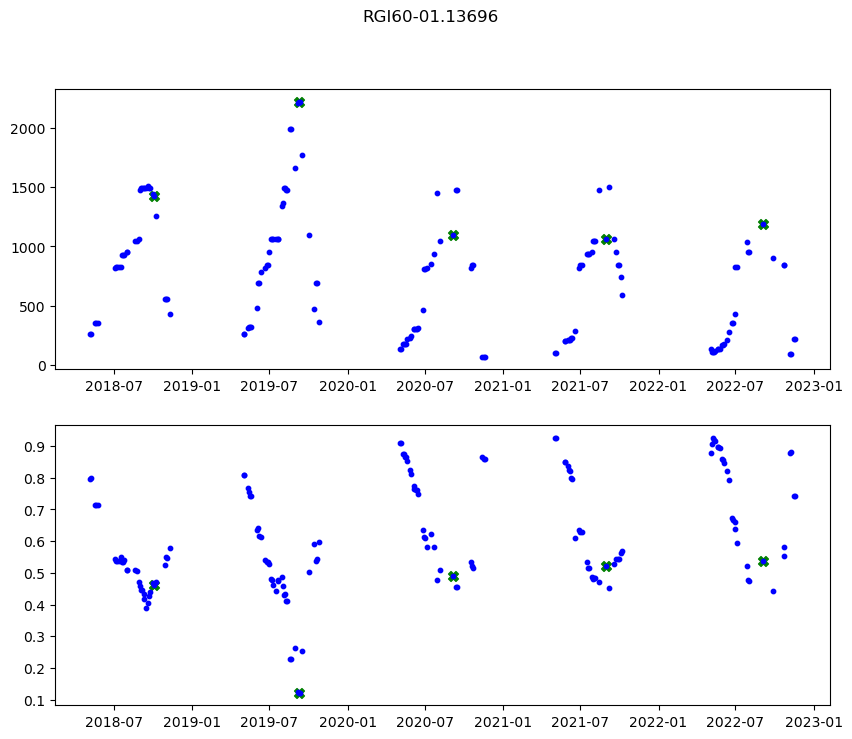

In [5]:
print(annual_best)
fig,axs = plt.subplots(2,1, figsize=(10,8))
marker = 'o'
size = 10
color='blue'
axs[0].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['ela'], marker=marker, s=size, c=color, zorder=5)
axs[1].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['aar'], marker=marker, s=size, c=color, zorder=5)

axs[0].scatter(pd.to_datetime(bad_dates), bad_elas, c='red')
axs[0].scatter(pd.to_datetime(bad_dates), expected_elas, c='orange')

axs[1].scatter(pd.to_datetime(bad_dates2), bad_elas2, c='red')
axs[1].scatter(pd.to_datetime(bad_dates2), expected_elas2, c='orange')
    
marker = 'X'
size = 50
color='green'
axs[0].scatter(pd.to_datetime(annual_best['date']), annual_best['ela'], marker=marker, s=size, c=color, zorder=1)
axs[1].scatter(pd.to_datetime(annual_best['date']), annual_best['aar'], marker=marker, s=size, c=color, zorder=1)

plt.suptitle(rgiid)